In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No EMA CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-noncyclic Stocks

##kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


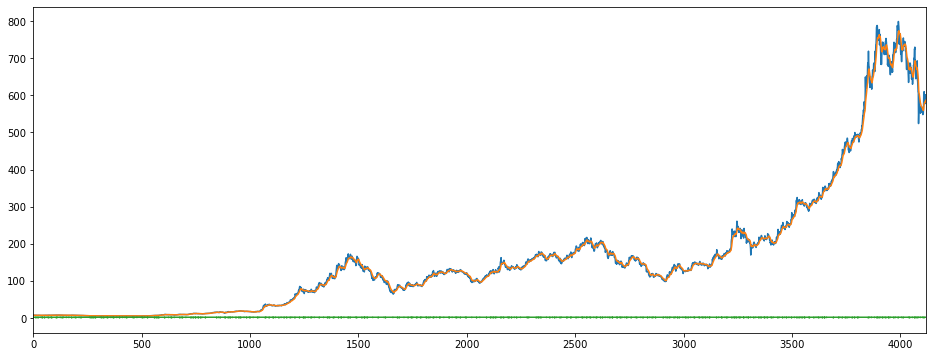

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0

In [8]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4106, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4106, 15, 1)

In [11]:
#ema_data = np.array(#ema_data)
#ema_data.shape

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4106, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4106, 64, 64, 1)

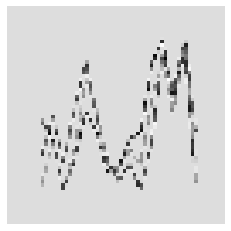

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.6134 - accuracy: 0.6328 - mse: 5.5499 - weighted_accuracy: 0.2853 - weighted_mse: 7.0863WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 25ms/step - loss: 0.2587 - accuracy: 0.3200 - mse: 1.8193 - weighted_accuracy: 0.3607 - weighted_mse: 1.9385 - val_loss: 0.2061 - val_accuracy: 0.0438 - val_mse: 0.9168 - val_weighted_accuracy: 0.0438 - val_weighted_mse: 0.9168
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2064 - accuracy: 0.2430 - mse: 1.1986 - weighted_accuracy: 0.3438 - weighted_mse: 1.1829 - val_loss: 0.1953 - val_accuracy: 0.0852 - val

Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1976 - accuracy: 0.2351 - mse: 1.1834 - weighted_accuracy: 0.3882 - weighted_mse: 1.1769 - val_loss: 0.2069 - val_accuracy: 0.0693 - val_mse: 1.0790 - val_weighted_accuracy: 0.0693 - val_weighted_mse: 1.0790
Epoch 28/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1959 - accuracy: 0.1827 - mse: 1.2334 - weighted_accuracy: 0.4249 - weighted_mse: 1.1887 - val_loss: 0.2046 - val_accuracy: 0.0645 - val_mse: 0.8994 - val_weighted_accuracy: 0.0645 - val_weighted_mse: 0.8994
Epoch 29/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1937 - accuracy: 0.2220 - mse: 1.2236 - weighted_accuracy: 0.4135 - weighted_mse: 1.1901 - val_loss: 0.2059 - val_accuracy: 0.0620 - val_mse: 1.1026 - val_weighted_accuracy: 0.0620 - val_weighted_mse: 1.1026
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1916 - accuracy: 0.1988 - mse: 1.2477 - weighted_accuracy: 0.4696 - weig

Epoch 56/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1752 - accuracy: 0.1861 - mse: 1.3707 - weighted_accuracy: 0.5642 - weighted_mse: 1.3329 - val_loss: 0.2006 - val_accuracy: 0.0742 - val_mse: 1.0746 - val_weighted_accuracy: 0.0742 - val_weighted_mse: 1.0746
Epoch 57/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1770 - accuracy: 0.1720 - mse: 1.2991 - weighted_accuracy: 0.5438 - weighted_mse: 1.2526 - val_loss: 0.1991 - val_accuracy: 0.0633 - val_mse: 1.1853 - val_weighted_accuracy: 0.0633 - val_weighted_mse: 1.1853
Epoch 58/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1780 - accuracy: 0.1714 - mse: 1.3365 - weighted_accuracy: 0.5221 - weighted_mse: 1.2881 - val_loss: 0.1994 - val_accuracy: 0.0681 - val_mse: 1.0962 - val_weighted_accuracy: 0.0681 - val_weighted_mse: 1.0962
Epoch 59/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1754 - accuracy: 0.1663 - mse: 1.3239 - weighted_accuracy: 0.5483 - weig

Epoch 85/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1615 - accuracy: 0.1821 - mse: 1.4645 - weighted_accuracy: 0.5929 - weighted_mse: 1.4302 - val_loss: 0.1986 - val_accuracy: 0.0852 - val_mse: 1.1466 - val_weighted_accuracy: 0.0852 - val_weighted_mse: 1.1466
Epoch 86/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1587 - accuracy: 0.1745 - mse: 1.4443 - weighted_accuracy: 0.5945 - weighted_mse: 1.4014 - val_loss: 0.1997 - val_accuracy: 0.1253 - val_mse: 1.2331 - val_weighted_accuracy: 0.1253 - val_weighted_mse: 1.2331
Epoch 87/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1569 - accuracy: 0.1891 - mse: 1.4945 - weighted_accuracy: 0.6299 - weighted_mse: 1.4749 - val_loss: 0.1962 - val_accuracy: 0.1375 - val_mse: 1.3883 - val_weighted_accuracy: 0.1375 - val_weighted_mse: 1.3883
Epoch 88/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1598 - accuracy: 0.1861 - mse: 1.4225 - weighted_accuracy: 0.6115 - 

26/26 [==============================] - 0s 10ms/step - loss: 0.1438 - accuracy: 0.2597 - mse: 1.5789 - weighted_accuracy: 0.6752 - weighted_mse: 1.6302 - val_loss: 0.1927 - val_accuracy: 0.2457 - val_mse: 1.4141 - val_weighted_accuracy: 0.2457 - val_weighted_mse: 1.4141
Epoch 114/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1447 - accuracy: 0.2518 - mse: 1.6504 - weighted_accuracy: 0.6508 - weighted_mse: 1.7053 - val_loss: 0.1932 - val_accuracy: 0.2518 - val_mse: 1.4346 - val_weighted_accuracy: 0.2518 - val_weighted_mse: 1.4346
Epoch 115/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1422 - accuracy: 0.2613 - mse: 1.5929 - weighted_accuracy: 0.6736 - weighted_mse: 1.6786 - val_loss: 0.1983 - val_accuracy: 0.2056 - val_mse: 1.4263 - val_weighted_accuracy: 0.2056 - val_weighted_mse: 1.4263
Epoch 116/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1467 - accuracy: 0.2597 - mse: 1.6321 - weighted_accuracy: 0.6644 - weighted_ms

26/26 [==============================] - 0s 11ms/step - loss: 0.1282 - accuracy: 0.4010 - mse: 1.8745 - weighted_accuracy: 0.7226 - weighted_mse: 2.1038 - val_loss: 0.1831 - val_accuracy: 0.4197 - val_mse: 1.5970 - val_weighted_accuracy: 0.4197 - val_weighted_mse: 1.5970
Epoch 142/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1282 - accuracy: 0.4108 - mse: 1.8510 - weighted_accuracy: 0.7024 - weighted_mse: 2.1140 - val_loss: 0.1830 - val_accuracy: 0.3832 - val_mse: 1.5888 - val_weighted_accuracy: 0.3832 - val_weighted_mse: 1.5888
Epoch 143/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1281 - accuracy: 0.4342 - mse: 1.8491 - weighted_accuracy: 0.7131 - weighted_mse: 2.0874 - val_loss: 0.1860 - val_accuracy: 0.4039 - val_mse: 1.7020 - val_weighted_accuracy: 0.4039 - val_weighted_mse: 1.7020
Epoch 144/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1281 - accuracy: 0.4220 - mse: 1.8640 - weighted_accuracy: 0.7282 - weighted_m

Epoch 170/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1154 - accuracy: 0.5432 - mse: 2.0990 - weighted_accuracy: 0.7617 - weighted_mse: 2.6012 - val_loss: 0.1619 - val_accuracy: 0.5718 - val_mse: 1.7907 - val_weighted_accuracy: 0.5718 - val_weighted_mse: 1.7907
Epoch 171/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1178 - accuracy: 0.5387 - mse: 2.0851 - weighted_accuracy: 0.7514 - weighted_mse: 2.6190 - val_loss: 0.1641 - val_accuracy: 0.5572 - val_mse: 1.7062 - val_weighted_accuracy: 0.5572 - val_weighted_mse: 1.7062
Epoch 172/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1101 - accuracy: 0.5423 - mse: 2.1517 - weighted_accuracy: 0.7808 - weighted_mse: 2.7762 - val_loss: 0.1585 - val_accuracy: 0.5985 - val_mse: 1.8478 - val_weighted_accuracy: 0.5985 - val_weighted_mse: 1.8478
Epoch 173/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1145 - accuracy: 0.5585 - mse: 2.1854 - weighted_accuracy: 0.7717 

Epoch 199/200
26/26 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.6541 - mse: 2.5145 - weighted_accuracy: 0.7860 - weighted_mse: 3.556 - 0s 9ms/step - loss: 0.1052 - accuracy: 0.6495 - mse: 2.5463 - weighted_accuracy: 0.7748 - weighted_mse: 3.5664 - val_loss: 0.1484 - val_accuracy: 0.6545 - val_mse: 1.9949 - val_weighted_accuracy: 0.6545 - val_weighted_mse: 1.9949
Epoch 200/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0973 - accuracy: 0.6449 - mse: 2.4580 - weighted_accuracy: 0.8118 - weighted_mse: 3.3890 - val_loss: 0.1400 - val_accuracy: 0.6995 - val_mse: 2.0058 - val_weighted_accuracy: 0.6995 - val_weighted_mse: 2.0058


In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14002396166324615
Test accuracy: 0.6995133757591248


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.0940008  -1.0436245  -0.08553866]
 [-1.2682855  -1.4415989   0.01087397]
 [-1.8271343  -0.78327715 -0.10444386]
 ...
 [-1.3565854  -0.843138   -0.16723976]
 [-1.3199152  -0.9097904  -0.14300093]
 [-2.6407604   0.15236428 -0.9102824 ]]


Counter({2: 602, 0: 108, 1: 112})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 822
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 26
actual sells but predicted buy: 0
actual predicted sells: 14
actual sells but predicted hold: 23
actual holds but predicted buy: 104
actual holds but predicted sell: 91
actual predicted holds: 553
Percentage buys correct: 21.62162162162162%
Percentage sells correct: 37.83783783783784%
Percentage holds correct: 73.93048128342247%
actual buys: 37
actual sells: 37
actual holds: 748


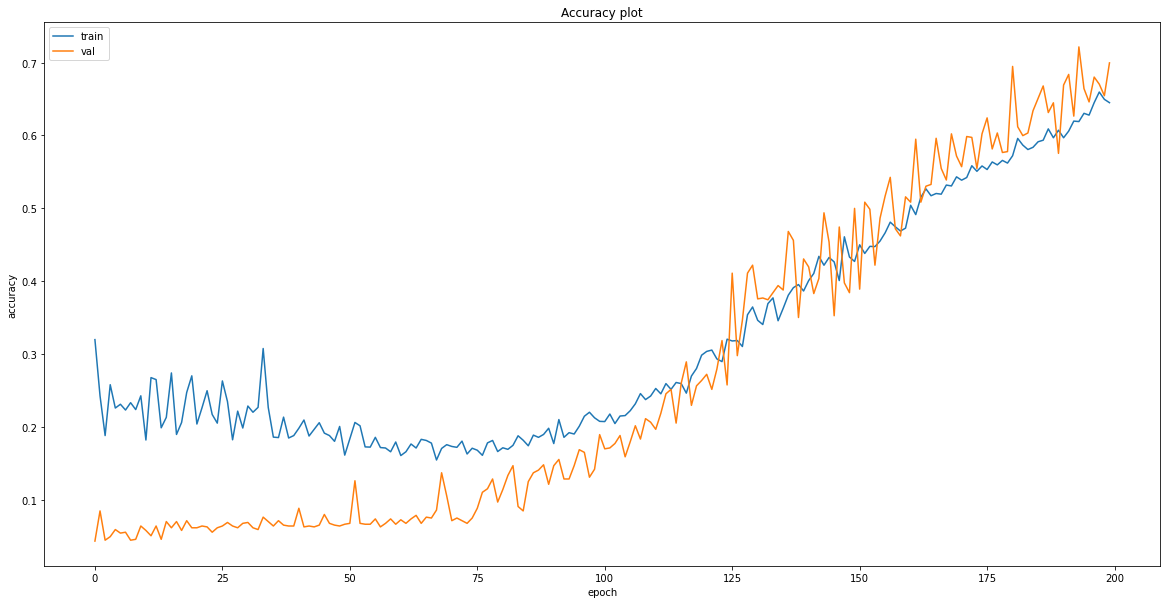

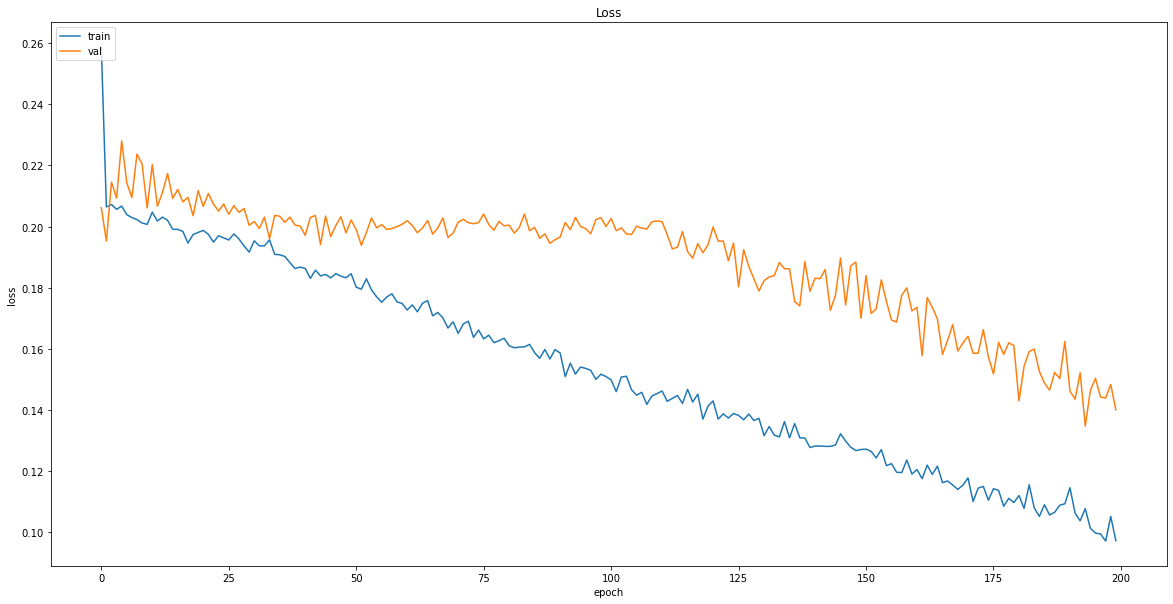

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_no_ema.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


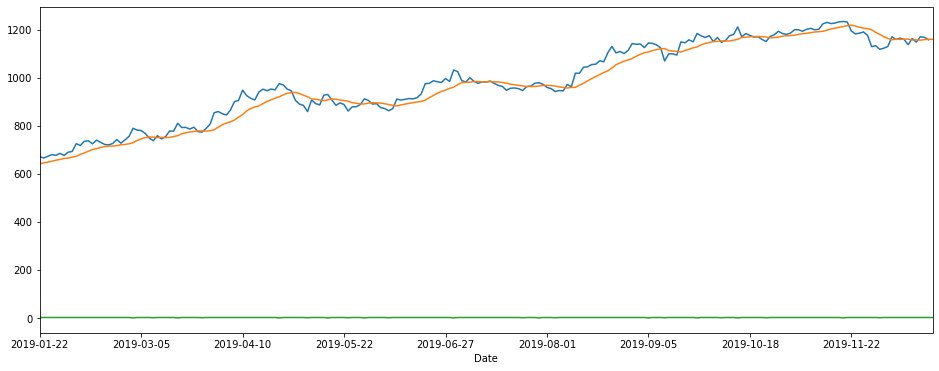

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# #ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# #data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         #data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         #ema_data.append(#data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         #data_15_ema = #data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         #data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1442 - accuracy: 0.6425 - mean_squared_error: 2.0718 - weighted_accuracy: 0.6425 - weighted_mean_squared_error: 2.0718
Test loss: 0.14417651295661926
Test accuracy: 0.6425120830535889


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 144, 1: 31, 0: 32})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [40]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-18    740.00000  704.389763 -23.444619  43919901.0     2.0   
2019-02-19    730.76001  709.868261  -6.049880  47694490.0     2.0   
2019-02-20    722.00000  713.082376 -17.677836  44744340.0     2.0   
2019-02-21    720.25000  714.454318 -29.824573  40956103.0     2.0   
2019-02-22    726.01001  715.345962 -32.098776  37971063.0     2.0   

            predictions  actual  
Date                             
2019-02-18            2       2  
2019-02-19            2       2  
2019-02-20            2       2  
2019-02-21            1       2  
2019-02-22            2       2

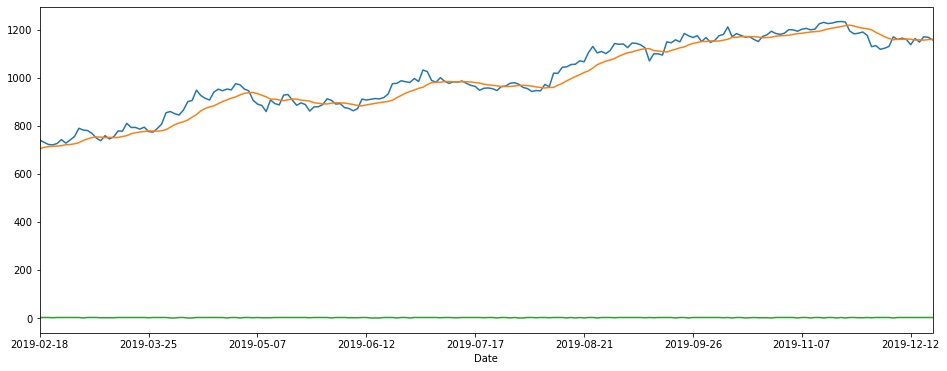

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

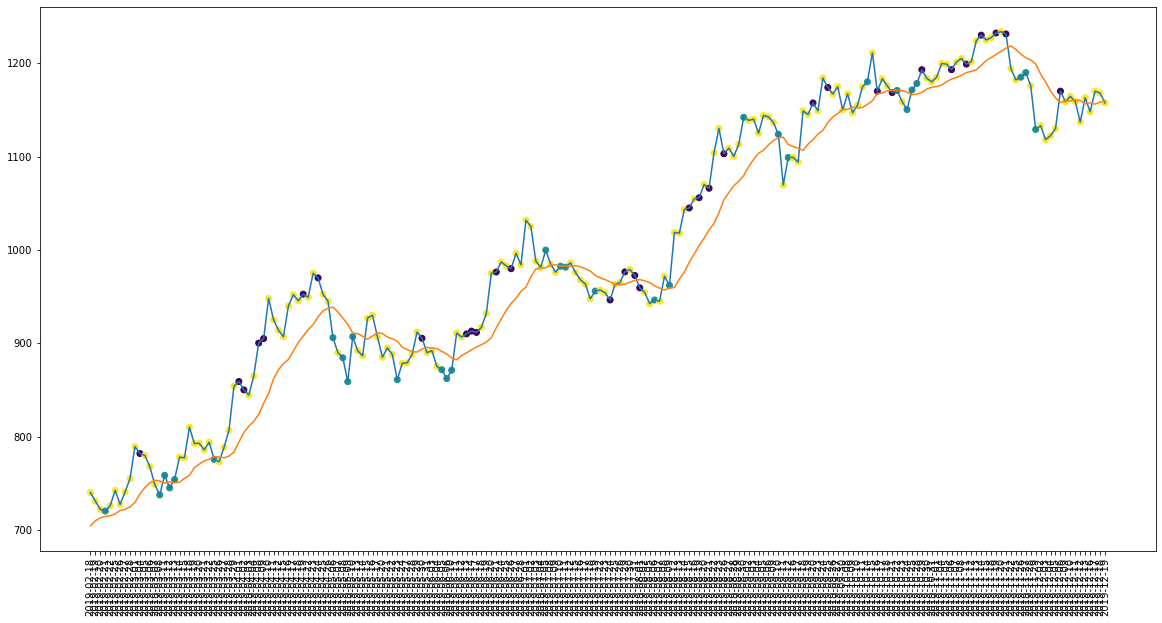

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

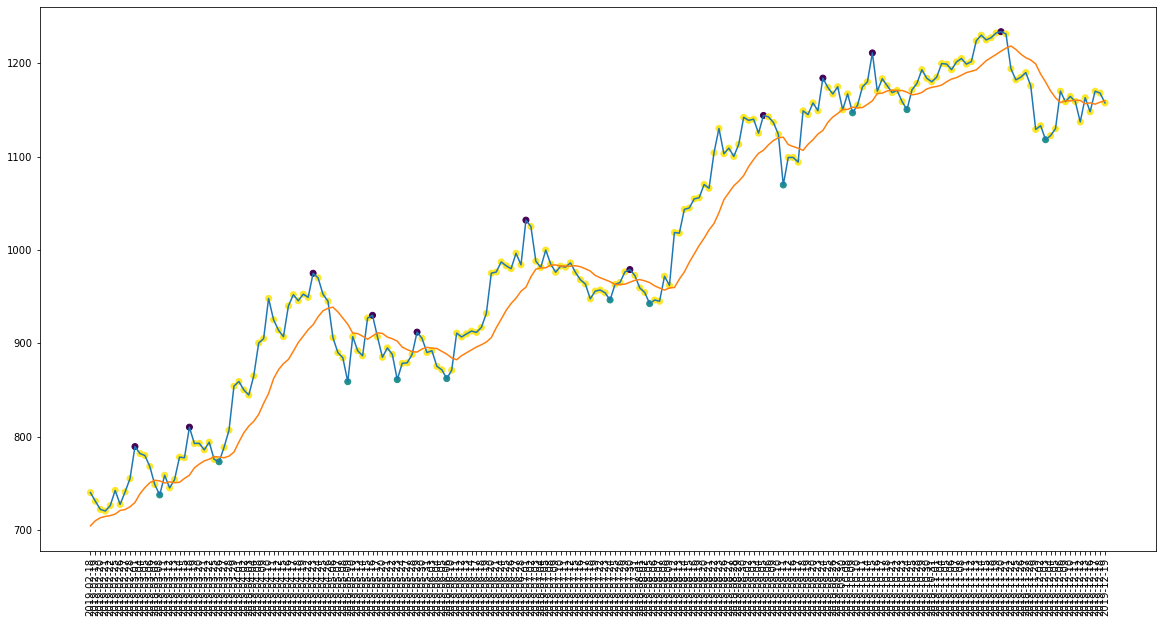

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 26
actual holds but predicted sell: 31
actual predicted holds: 128
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 0.0%
Percentage holds correct: 69.1891891891892%
actual buys: 11
actual sells: 11
actual holds: 185


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 58.064516129032256%
Percentage sells correct: 46.875%
Percentage holds correct: 84.61538461538461%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $720.25
Shares owned at the moment: 13
Cash capital at the moment: $611.0010624999995


Price increase from previously bought: 8.256267544926565%
Share price: $781.8599853515625
Shares owned at the moment: 0
Cash capital at the moment: $10747.229377593992


Share price: $737.5
Shares owned at the moment: 14
Cash capital at the moment: $393.8356275939914


Price increase from previously bought: 16.15514960975959%
Share price: $859.0
Shares owned at the moment: 0
Cash capital at the moment: $12386.764127593991


Share price: $906.0
Shares owned at the moment: 13
Cash capital at the moment: $576.3746275939902


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $11710.202138442988


Share price: $858.8099975585938
Shares owned at the moment: 13
Cash capital at the moment: $514.9697127685486


Price increase from previously bought: 5.1242117521253405%
Share price: $905.2999877929688
Shares owned at the moment: 0
Cash

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys correct_sells      correct_holds  \
0       0.642512  45.45454545454545%          0.0%  69.1891891891892%   

      correct_low_buys correct_high_sells   correct_mid_holds  \
0  58.064516129032256%            46.875%  84.61538461538461%   

        Profit gained  buy_n_hold profit  
0  35.44242451446518%  53.5836826651001%

### Recession

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


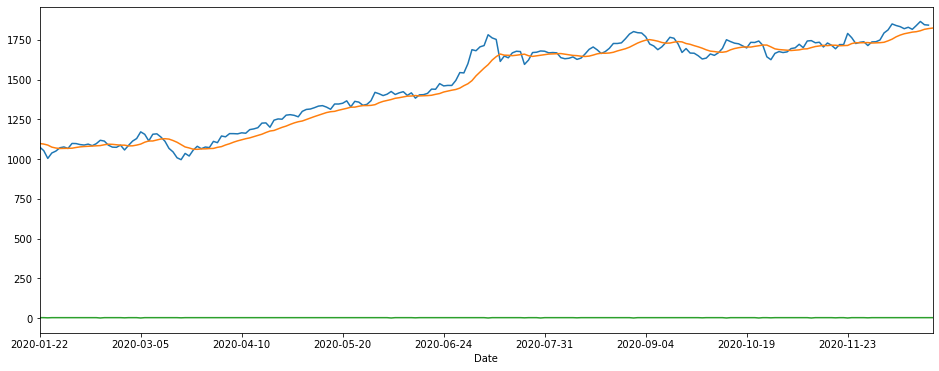

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1361 - accuracy: 0.6923 - mean_squared_error: 1.9746 - weighted_accuracy: 0.6923 - weighted_mean_squared_error: 1.9746
Test loss: 0.13612495362758636
Test accuracy: 0.692307710647583


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 147, 0: 37, 1: 24})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d       EMA_12   willr_14      OBV_7  labels  \
Date                                                                 
2020-02-19  1096.500000  1082.513705 -22.324305  -423291.0     2.0   
2020-02-20  1118.000000  1084.665443 -12.988283  3281856.0     0.0   
2020-02-21  1112.880005  1089.793836  -4.166667  7962118.0     2.0   
2020-02-24  1087.180054  1093.345554 -10.201830  5068110.0     2.0   
2020-02-25  1074.810059  1092.397016 -40.474836  1203074.0     2.0   

            predictions  actual  
Date                             
2020-02-19            2       2  
2020-02-20            0       0  
2020-02-21            0       2  
2020-02-24            2       2  
2020-02-25            2       2

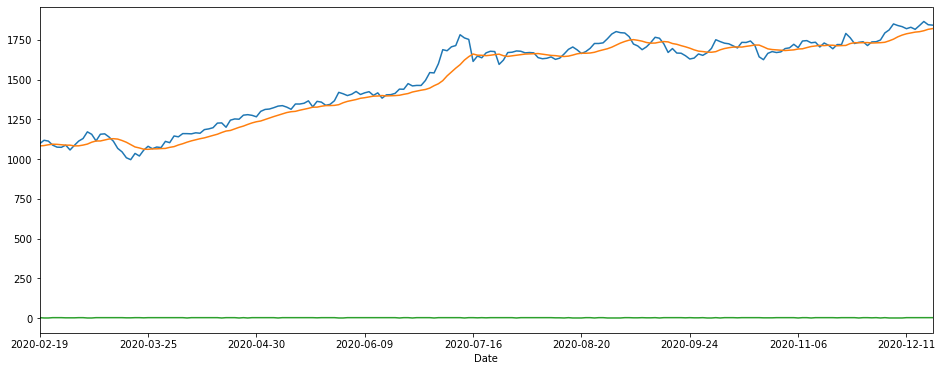

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

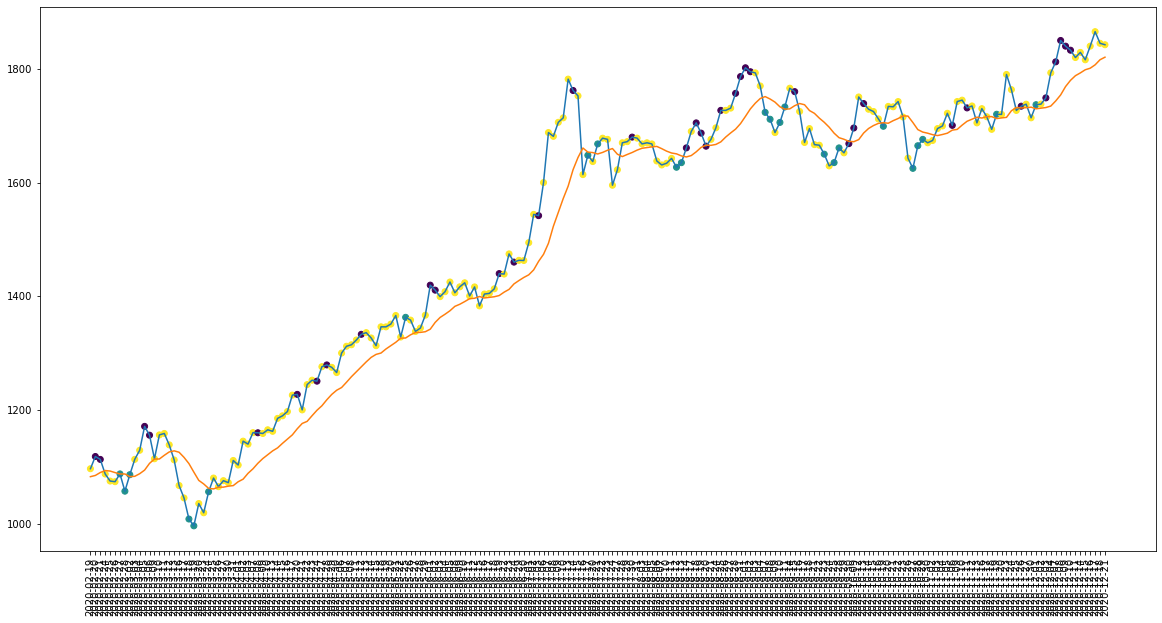

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

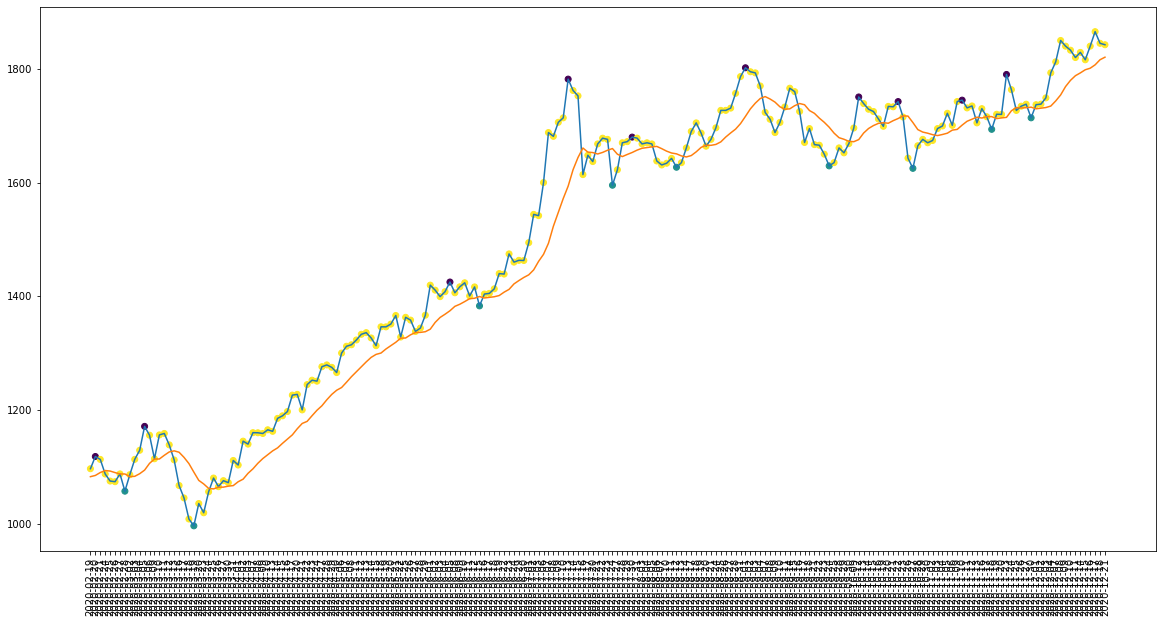

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 33
actual predicted holds: 136
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 40.0%
Percentage holds correct: 71.95767195767196%
actual buys: 9
actual sells: 10
actual holds: 189


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 62.16216216216216%
Percentage holds correct: 86.3013698630137%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1087.3900146484377
Shares owned at the moment: 9
Cash capital at the moment: $186.57696530151225


Stop Loss Activated!

Share price: $1057.0
Shares owned at the moment: 0
Cash capital at the moment: $9673.416215301511


Share price: $1057.0
Shares owned at the moment: 9
Cash capital at the moment: $134.2554653015104


Price increase from previously bought: 10.481417351101863%
Share price: $1171.0
Shares owned at the moment: 0
Cash capital at the moment: $10644.27321530151


Share price: $1007.989990234375
Shares owned at the moment: 10
Cash capital at the moment: $536.6535882263142


Price increase from previously bought: 14.741160882131489%
Share price: $1159.760009765625
Shares owned at the moment: 0
Cash capital at the moment: $12102.36028561401


Share price: $1362.9000244140625
Shares owned at the moment: 8
Cash capital at the moment: $1169.1762897644003


Price increase from previously bought: 5.355582883587884%
Share price: $1439.8399658203125
Shares owned at the 

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys correct_sells       correct_holds  \
0       0.642512  45.45454545454545%          0.0%   69.1891891891892%   
1       0.692308  44.44444444444444%         40.0%  71.95767195767196%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0  58.064516129032256%             46.875%  84.61538461538461%   
1   66.66666666666667%  62.16216216216216%   86.3013698630137%   

         Profit gained   buy_n_hold profit  
0   35.44242451446518%   53.5836826651001%  
1  37.830041926574616%  66.41259749999998%

### Midea Group

In [71]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


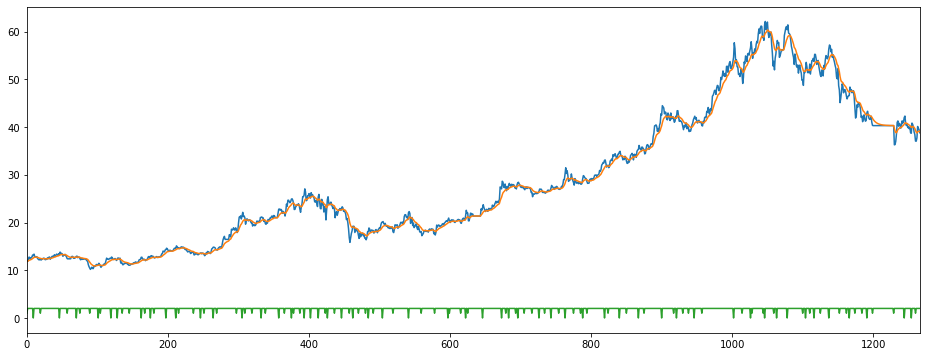

In [72]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [73]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0

In [74]:
# willr_data = []
# price_data = []
# #ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# #data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         #data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         #ema_data.append(#data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         #data_15_ema = #data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         #data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [75]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [76]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [78]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1253, 64, 64, 1)

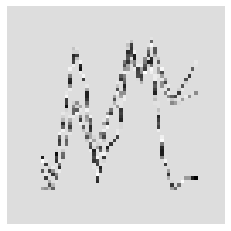

In [79]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [80]:
X = X/255

In [81]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [82]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [83]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [85]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.9523809523809526, 1: 6.816326530612245, 2: 0.36663007683863885}
Epoch 1/200
8/8 [==============================] - 4s 438ms/step - loss: 0.3146 - accuracy: 0.4351 - mse: 2.8732 - weighted_accuracy: 0.3647 - weighted_mse: 2.8599 - val_loss: 0.1795 - val_accuracy: 0.8884 - val_mse: 1.2208 - val_weighted_accuracy: 0.8884 - val_weighted_mse: 1.2208
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.2263 - accuracy: 0.3383 - mse: 1.2455 - weighted_accuracy: 0.3372 - weighted_mse: 1.2668 - val_loss: 0.2229 - val_accuracy: 0.0518 - val_mse: 0.9265 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.9265
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2094 - accuracy: 0.2375 - mse: 1.2743 - weighted_accuracy: 0.3097 - weighted_mse: 1.2380 - val_loss: 0.1916 - val_accuracy: 0.6932 - val_mse: 0.9936 - val_weighted_accuracy: 0.6932 - val_weighted_mse: 0.9936
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1998 - ac

Epoch 29/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2052 - accuracy: 0.4032 - mse: 1.1948 - weighted_accuracy: 0.3375 - weighted_mse: 1.1708 - val_loss: 0.1935 - val_accuracy: 0.4701 - val_mse: 0.9253 - val_weighted_accuracy: 0.4701 - val_weighted_mse: 0.9253
Epoch 30/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2017 - accuracy: 0.4491 - mse: 1.0962 - weighted_accuracy: 0.3956 - weighted_mse: 1.0916 - val_loss: 0.1915 - val_accuracy: 0.7610 - val_mse: 0.8917 - val_weighted_accuracy: 0.7610 - val_weighted_mse: 0.8917
Epoch 31/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1971 - accuracy: 0.4760 - mse: 1.1518 - weighted_accuracy: 0.3922 - weighted_mse: 1.1478 - val_loss: 0.1713 - val_accuracy: 0.9084 - val_mse: 1.0217 - val_weighted_accuracy: 0.9084 - val_weighted_mse: 1.0217
Epoch 32/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2005 - accuracy: 0.4661 - mse: 1.2876 - weighted_accuracy: 0.3734 - weighted

Epoch 58/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1969 - accuracy: 0.2565 - mse: 1.0870 - weighted_accuracy: 0.4113 - weighted_mse: 1.1231 - val_loss: 0.2004 - val_accuracy: 0.1753 - val_mse: 0.9927 - val_weighted_accuracy: 0.1753 - val_weighted_mse: 0.9927
Epoch 59/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1973 - accuracy: 0.3024 - mse: 1.2918 - weighted_accuracy: 0.4232 - weighted_mse: 1.2562 - val_loss: 0.1990 - val_accuracy: 0.0797 - val_mse: 1.0836 - val_weighted_accuracy: 0.0797 - val_weighted_mse: 1.0836
Epoch 60/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1935 - accuracy: 0.3154 - mse: 1.1790 - weighted_accuracy: 0.4461 - weighted_mse: 1.1334 - val_loss: 0.1919 - val_accuracy: 0.2988 - val_mse: 1.1009 - val_weighted_accuracy: 0.2988 - val_weighted_mse: 1.1009
Epoch 61/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1911 - accuracy: 0.3293 - mse: 1.2157 - weighted_accuracy: 0.4944 - weighted

Epoch 87/200
8/8 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.2585 - mse: 1.2070 - weighted_accuracy: 0.5555 - weighted_mse: 1.170 - 0s 10ms/step - loss: 0.1806 - accuracy: 0.2585 - mse: 1.2070 - weighted_accuracy: 0.5555 - weighted_mse: 1.1709 - val_loss: 0.1928 - val_accuracy: 0.2430 - val_mse: 1.0976 - val_weighted_accuracy: 0.2430 - val_weighted_mse: 1.0976
Epoch 88/200
8/8 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.3014 - mse: 1.2748 - weighted_accuracy: 0.5349 - weighted_mse: 1.256 - 0s 11ms/step - loss: 0.1803 - accuracy: 0.3014 - mse: 1.2748 - weighted_accuracy: 0.5349 - weighted_mse: 1.2562 - val_loss: 0.1933 - val_accuracy: 0.2191 - val_mse: 1.0611 - val_weighted_accuracy: 0.2191 - val_weighted_mse: 1.0611
Epoch 89/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1861 - accuracy: 0.2924 - mse: 1.2140 - weighted_accuracy: 0.5327 - weighted_mse: 1.1706 - val_loss: 0.1966 - val_accuracy: 0.2271 - val_mse: 1

8/8 [==============================] - 0s 11ms/step - loss: 0.1630 - accuracy: 0.2784 - mse: 1.2681 - weighted_accuracy: 0.6419 - weighted_mse: 1.2395 - val_loss: 0.1946 - val_accuracy: 0.2351 - val_mse: 1.1080 - val_weighted_accuracy: 0.2351 - val_weighted_mse: 1.1080
Epoch 116/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1741 - accuracy: 0.2874 - mse: 1.3217 - weighted_accuracy: 0.5684 - weighted_mse: 1.2637 - val_loss: 0.1943 - val_accuracy: 0.2112 - val_mse: 1.0665 - val_weighted_accuracy: 0.2112 - val_weighted_mse: 1.0665
Epoch 117/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1666 - accuracy: 0.3204 - mse: 1.2215 - weighted_accuracy: 0.6130 - weighted_mse: 1.2470 - val_loss: 0.1995 - val_accuracy: 0.2032 - val_mse: 1.0685 - val_weighted_accuracy: 0.2032 - val_weighted_mse: 1.0685
Epoch 118/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1628 - accuracy: 0.2884 - mse: 1.3593 - weighted_accuracy: 0.6176 - weighted_mse: 1.40

Epoch 144/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1565 - accuracy: 0.3283 - mse: 1.3132 - weighted_accuracy: 0.6171 - weighted_mse: 1.3555 - val_loss: 0.1939 - val_accuracy: 0.3147 - val_mse: 1.0873 - val_weighted_accuracy: 0.3147 - val_weighted_mse: 1.0873
Epoch 145/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1565 - accuracy: 0.3074 - mse: 1.3111 - weighted_accuracy: 0.6374 - weighted_mse: 1.3586 - val_loss: 0.1954 - val_accuracy: 0.3068 - val_mse: 1.0414 - val_weighted_accuracy: 0.3068 - val_weighted_mse: 1.0414
Epoch 146/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1506 - accuracy: 0.3214 - mse: 1.2974 - weighted_accuracy: 0.6899 - weighted_mse: 1.2994 - val_loss: 0.1906 - val_accuracy: 0.3426 - val_mse: 1.1718 - val_weighted_accuracy: 0.3426 - val_weighted_mse: 1.1718
Epoch 147/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1493 - accuracy: 0.3154 - mse: 1.4217 - weighted_accuracy: 0.6498 - weig

Epoch 173/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1375 - accuracy: 0.3772 - mse: 1.4933 - weighted_accuracy: 0.7039 - weighted_mse: 1.6006 - val_loss: 0.1840 - val_accuracy: 0.4462 - val_mse: 1.1659 - val_weighted_accuracy: 0.4462 - val_weighted_mse: 1.1659
Epoch 174/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1458 - accuracy: 0.3403 - mse: 1.4356 - weighted_accuracy: 0.6362 - weighted_mse: 1.4235 - val_loss: 0.1895 - val_accuracy: 0.4343 - val_mse: 1.1266 - val_weighted_accuracy: 0.4343 - val_weighted_mse: 1.1266
Epoch 175/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1431 - accuracy: 0.3703 - mse: 1.4097 - weighted_accuracy: 0.6540 - weighted_mse: 1.5723 - val_loss: 0.1882 - val_accuracy: 0.3825 - val_mse: 1.1426 - val_weighted_accuracy: 0.3825 - val_weighted_mse: 1.1426
Epoch 176/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1405 - accuracy: 0.3762 - mse: 1.4454 - weighted_accuracy: 0.6873 - weig

In [86]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1814103126525879
Test accuracy: 0.5059760808944702


In [87]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-8.3783233e-01 -5.1704186e-01 -3.5731444e-01]
 [-4.3344557e-01 -7.1987945e-01 -3.8300419e-01]
 [-4.5779583e-01 -6.6433775e-01 -3.4096989e-01]
 [-1.4884697e+00 -1.6187756e-01 -6.2634528e-01]
 [-7.3008573e-01 -5.3301859e-01 -3.2576597e-01]
 [-2.8405607e-01 -8.5363984e-01 -4.1407016e-01]
 [-1.6140498e+00 -1.5436405e-01 -6.8603671e-01]
 [-1.2216356e-01 -1.0922120e+00 -5.0764108e-01]
 [-1.2326871e+00 -3.0725160e-01 -4.6649662e-01]
 [-7.5586629e-01 -3.5677817e-01 -2.8031582e-01]
 [-7.4519110e-01 -7.1584719e-01 -4.0806609e-01]
 [-7.8322363e-01 -6.5848517e-01 -3.8124821e-01]
 [-5.8751822e-01 -8.1285596e-01 -4.1325131e-01]
 [-3.9703164e-01 -9.5373881e-01 -4.5789412e-01]
 [-7.6720381e-01 -4.3142346e-01 -3.7064818e-01]
 [-1.7347580e-01 -1.2277807e+00 -5.3368133e-01]
 [-1.4762162e+00 -9.7979739e-02 -6.6220391e-01]
 [-5.6203687e-01 -7.6095080e-01 -3.7404981e-01]
 [-2.7799600e-01 -1.1305356e+00 -5.0988758e-01]
 [-4.7490898e-01 -7.2030842e-01 -3.7509668e-01]
 [-9.1111624e-01 -5.6347740e-01 -3.86248

Counter({2: 121, 1: 58, 0: 72})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [89]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 49
actual holds but predicted sell: 64
actual predicted holds: 115
Percentage buys correct: 53.84615384615385%
Percentage sells correct: 50.0%
Percentage holds correct: 50.43859649122807%
actual buys: 13
actual sells: 10
actual holds: 228


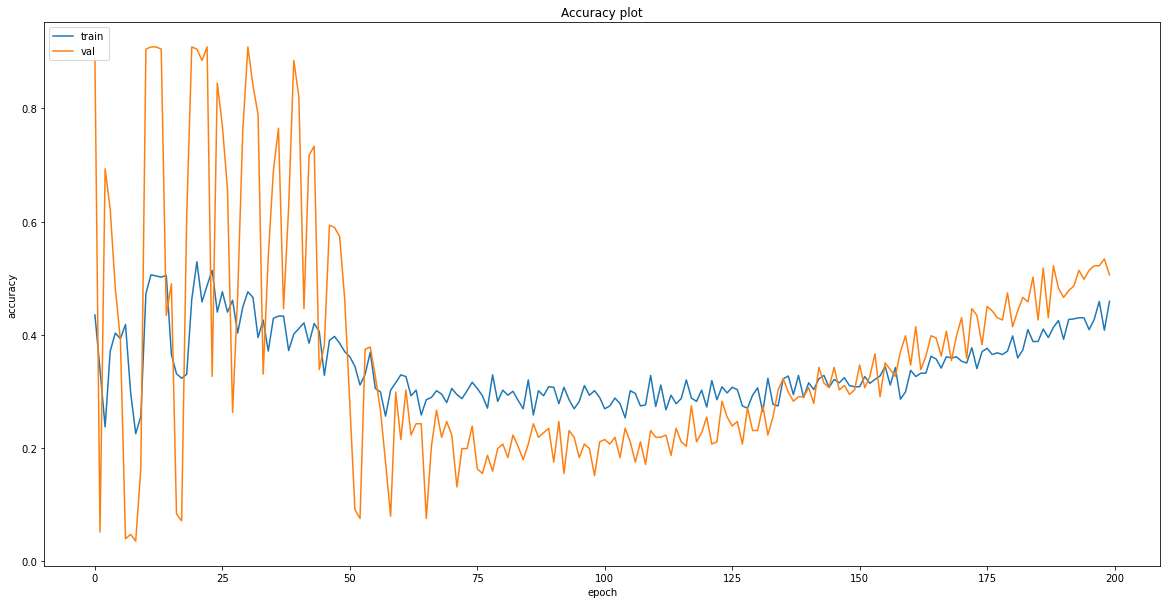

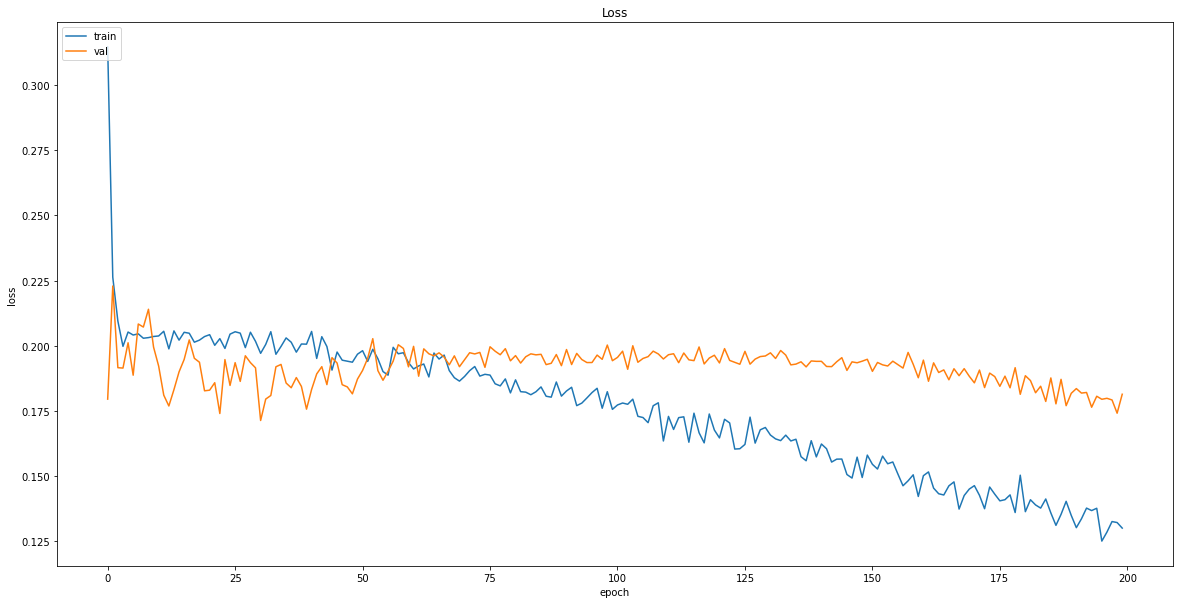

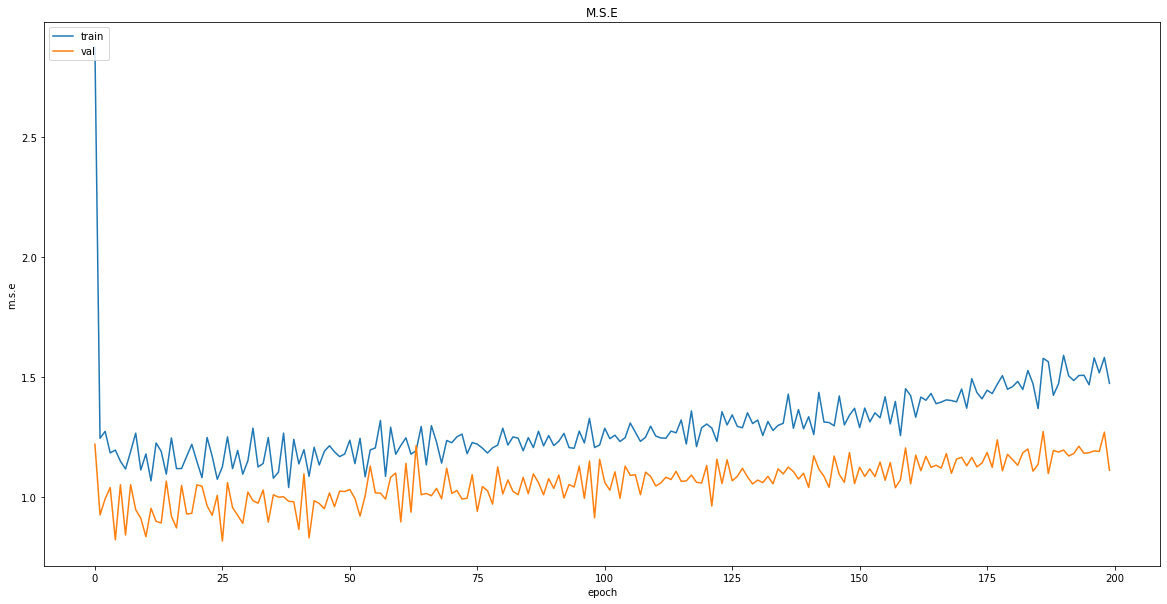

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [91]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

#### Non-Recession

In [92]:
logger = []

In [93]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


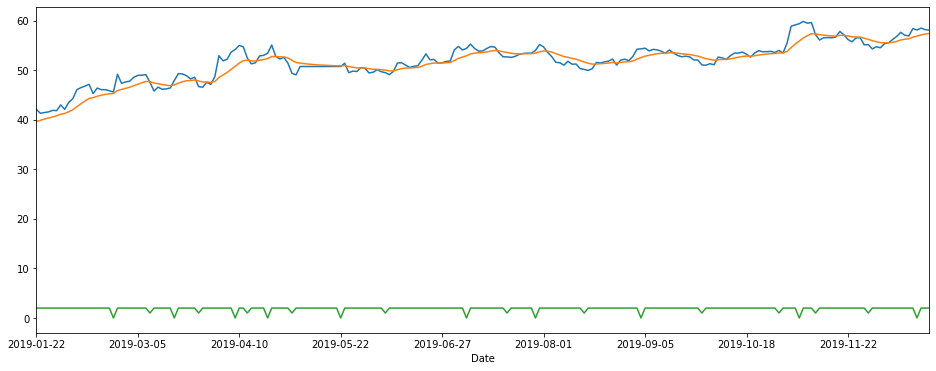

In [94]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

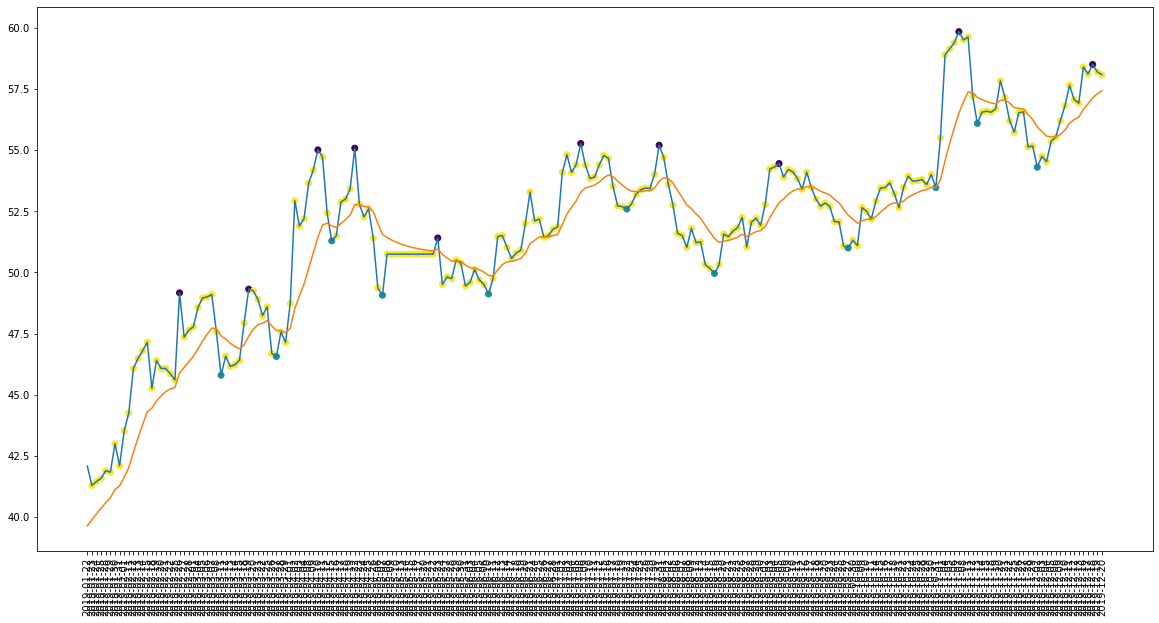

In [95]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [96]:
# willr_data = []
# price_data = []
# #ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# #data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         #data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         #ema_data.append(#data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         #data_15_ema = #data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         #data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# #ema_data = np.array(#ema_data)
# obv_data = np.array(obv_data)

In [97]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [99]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [100]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [101]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1839 - accuracy: 0.4348 - mean_squared_error: 1.1264 - weighted_accuracy: 0.4348 - weighted_mean_squared_error: 1.1264
Test loss: 0.18389326333999634
Test accuracy: 0.43478259444236755


In [102]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 91, 1: 53, 0: 63})

In [103]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [104]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [105]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [106]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-18    46.400002  44.456141 -30.862341  419918481.0     2.0   
2019-02-19    46.080002  44.755197 -13.767016  452488699.0     2.0   
2019-02-20    46.080002  44.959013 -18.975880  424412835.0     2.0   
2019-02-21    45.860001  45.131473 -18.975880  424412835.0     2.0   
2019-02-22    45.610001  45.243554 -26.174460  382970560.0     2.0   

            predictions  actual  
Date                             
2019-02-18            2       2  
2019-02-19            1       2  
2019-02-20            1       2  
2019-02-21            2       2  
2019-02-22            0       2

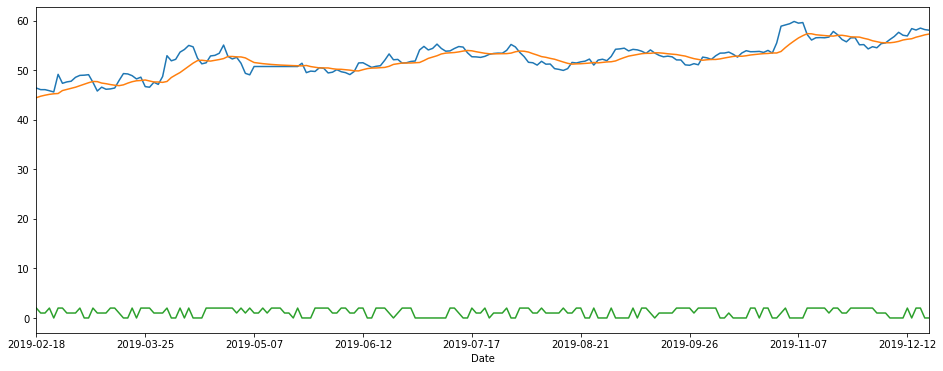

In [107]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

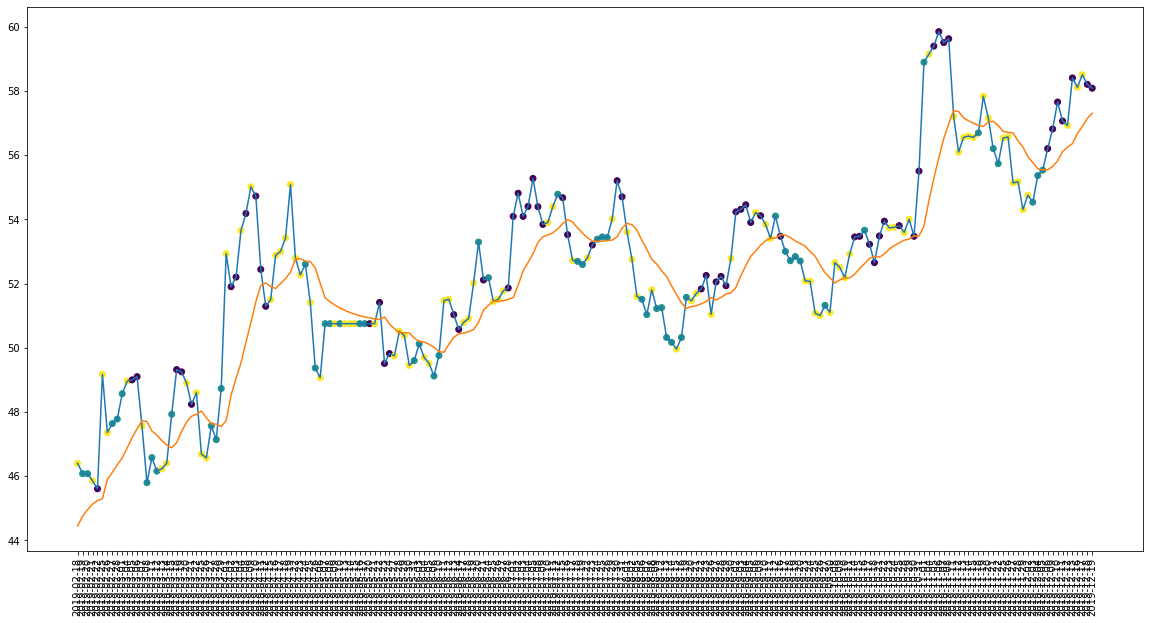

In [108]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

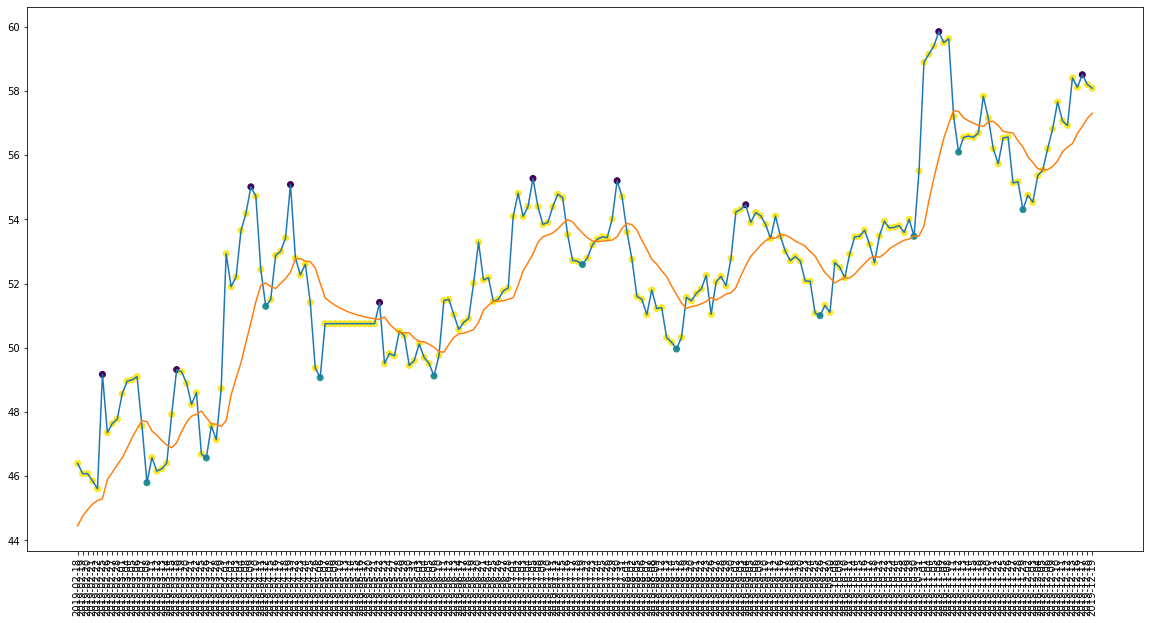

In [109]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [110]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 50
actual holds but predicted sell: 55
actual predicted holds: 81
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 60.0%
Percentage holds correct: 43.54838709677419%
actual buys: 11
actual sells: 10
actual holds: 186


In [111]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 56.60377358490566%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 78.88888888888889%


In [112]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.08000183105469
Shares owned at the moment: 216
Cash capital at the moment: $19.348083404540375


Price increase from previously bought: 6.045177093104659%
Share price: $49.0
Shares owned at the moment: 0
Cash capital at the moment: $10574.24208340454


Share price: $45.79999923706055
Shares owned at the moment: 230
Cash capital at the moment: $11.273759363173667


Price increase from previously bought: 7.390267411779328%
Share price: $49.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $11323.678789365767


Share price: $47.56999969482422
Shares owned at the moment: 237
Cash capital at the moment: $18.585114391325988


Price increase from previously bought: 8.803170635037727%
Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $12285.059650030133


Share price: $52.599998474121094
Shares owned at the moment: 232
Cash capital at the moment: $48.30120500754856


Stop Loss Activated!

Share price: $49.3699989318

In [113]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [114]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys correct_sells       correct_holds  \
0       0.642512   45.45454545454545%          0.0%   69.1891891891892%   
1       0.692308   44.44444444444444%         40.0%  71.95767195767196%   
2       0.434783  27.272727272727273%         60.0%  43.54838709677419%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0  58.064516129032256%             46.875%  84.61538461538461%   
1   66.66666666666667%  62.16216216216216%   86.3013698630137%   
2   56.60377358490566%  55.55555555555556%  78.88888888888889%   

         Profit gained    buy_n_hold profit  
0   35.44242451446518%    53.5836826651001%  
1  37.830041926574616%   66.41259749999998%  
2  24.980641415471876%  24.380335833320625%

#### Recession

In [115]:
logger = []

In [116]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


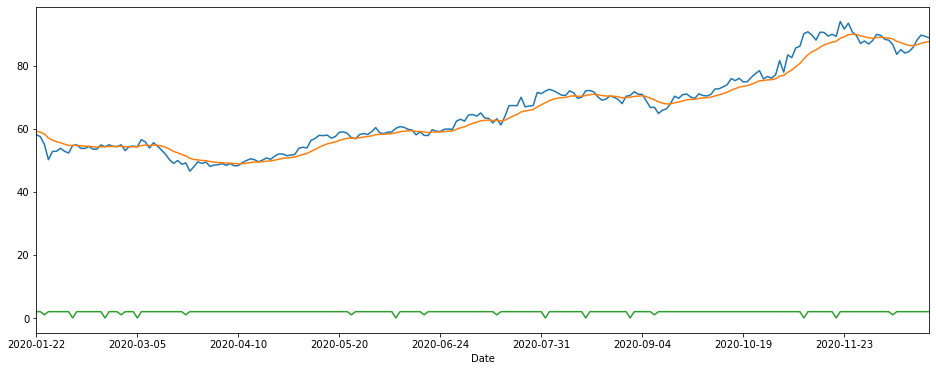

In [117]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

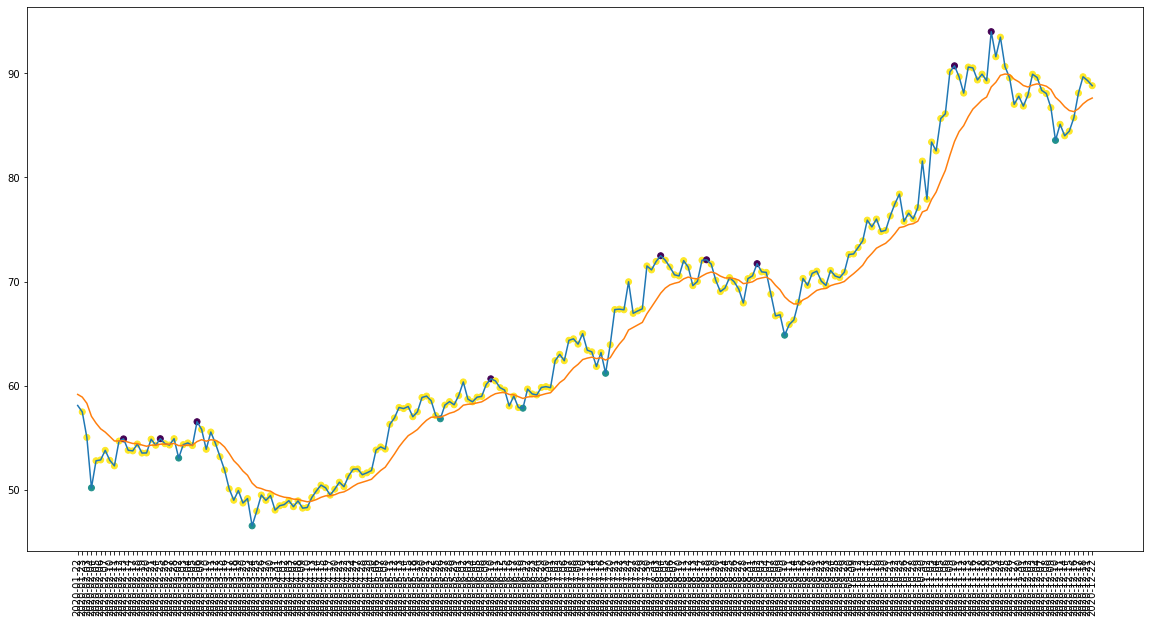

In [118]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [119]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [121]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [122]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [123]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.3990 - mean_squared_error: 1.1195 - weighted_accuracy: 0.3990 - weighted_mean_squared_error: 1.1195
Test loss: 0.18418441712856293
Test accuracy: 0.3990384638309479


In [124]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 89, 0: 68, 1: 51})

In [125]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [126]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [127]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-19    53.540001  54.301035 -52.927131 -33290149.0     2.0   
2020-02-20    54.860001  54.183953 -44.755246  -9557295.0     2.0   
2020-02-21    54.279999  54.287960  -8.665511  27483857.0     2.0   
2020-02-24    54.910000  54.286736 -21.343904  -2296012.0     0.0   
2020-02-25    54.430000  54.382622 -12.602723  38486402.0     2.0   

            predictions  actual  
Date                             
2020-02-19            2       2  
2020-02-20            2       2  
2020-02-21            0       2  
2020-02-24            2       0  
2020-02-25            0       2

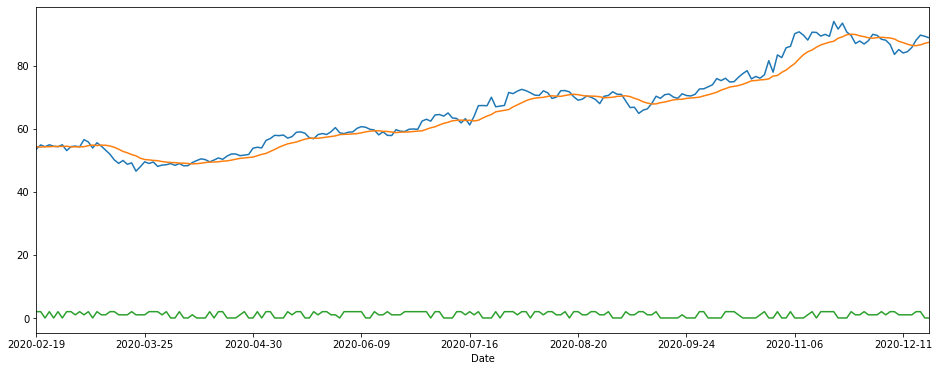

In [128]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

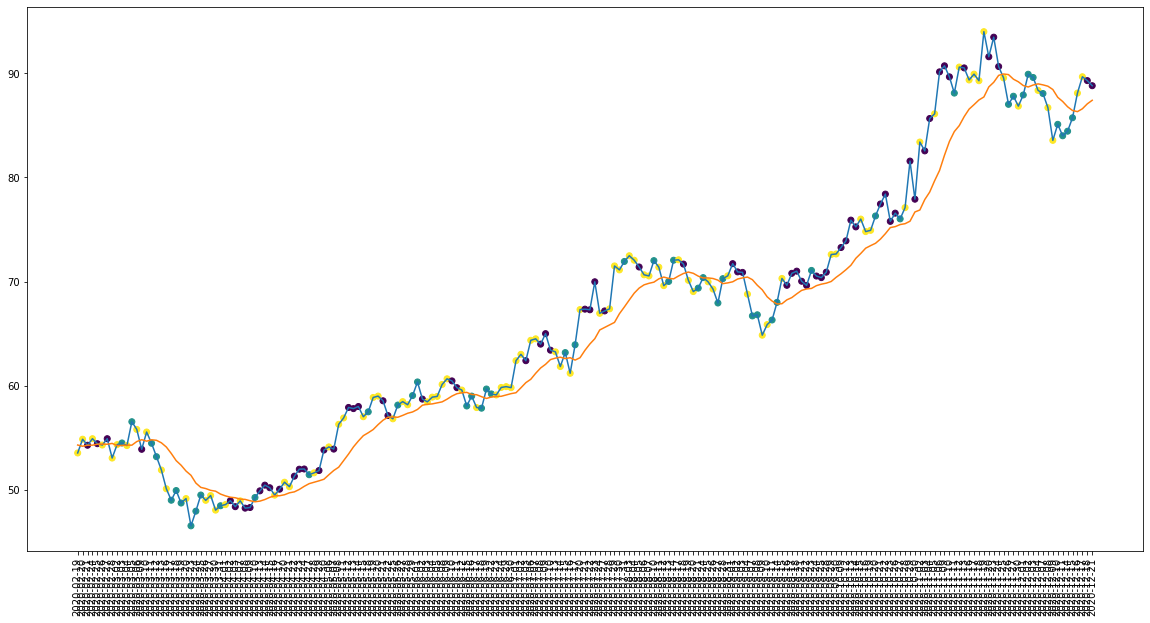

In [129]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

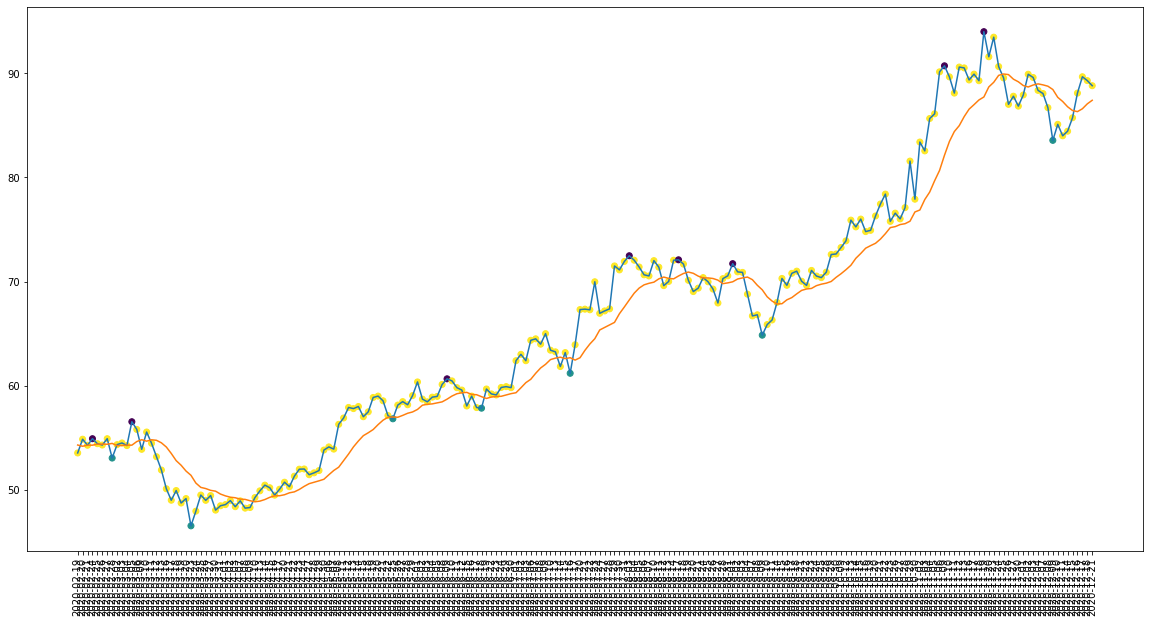

In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [131]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 48
actual holds but predicted sell: 66
actual predicted holds: 79
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 25.0%
Percentage holds correct: 40.932642487046635%
actual buys: 7
actual sells: 8
actual holds: 193


In [132]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 52.0%
Percentage sells correct: 54.411764705882355%
Percentage holds correct: 82.02247191011236%


In [133]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.5
Shares owned at the moment: 182
Cash capital at the moment: $53.722749999998996


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9473.547076946255


Share price: $49.0
Shares owned at the moment: 192
Cash capital at the moment: $39.67507694625601


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8950.782132244107


Share price: $46.540000915527344
Shares owned at the moment: 191
Cash capital at the moment: $37.19682189750347


Price increase from previously bought: 6.925551947987829%
Share price: $49.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9541.887137538904


Share price: $51.45000076293945
Shares owned at the moment: 184
Cash capital at the moment: $49.05329677199734


Price increase from previously bought: 12.24719773524443%
Share price: $57.90999984741211
Shares owned at the moment: 0
Cash capital at th

In [134]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [135]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys correct_sells        correct_holds  \
0       0.642512   45.45454545454545%          0.0%    69.1891891891892%   
1       0.692308   44.44444444444444%         40.0%   71.95767195767196%   
2       0.434783  27.272727272727273%         60.0%   43.54838709677419%   
3       0.399038  28.571428571428573%         25.0%  40.932642487046635%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0  58.064516129032256%              46.875%  84.61538461538461%   
1   66.66666666666667%   62.16216216216216%   86.3013698630137%   
2   56.60377358490566%   55.55555555555556%  78.88888888888889%   
3                52.0%  54.411764705882355%  82.02247191011236%   

         Profit gained    buy_n_hold profit  
0   35.44242451446518%    53.5836826651001%  
1  37.830041926574616%   66.41259749999998%  
2  24.980641415471876%  24.380335833320625%  
3   37.40646288772567%   64.87407351390837%

## Walmart

In [136]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


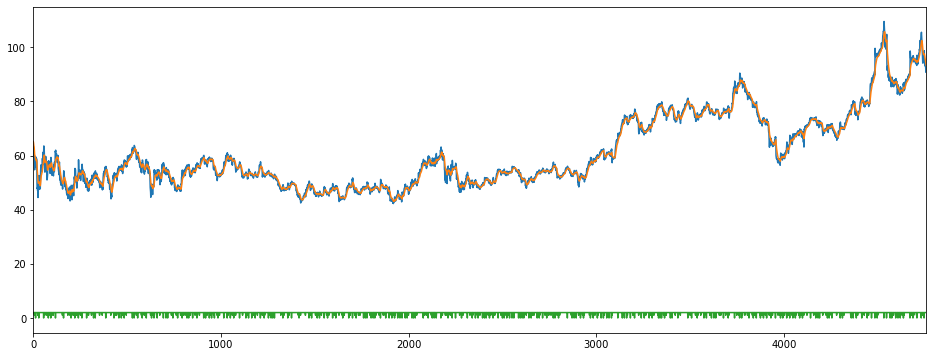

In [137]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [138]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0

In [139]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [140]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [142]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

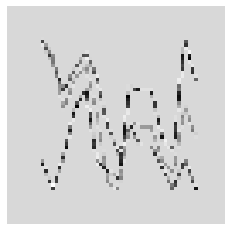

In [143]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [144]:
X = X/255

In [145]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [146]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [147]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [149]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.148775894538606, 1: 7.3565891472868215, 2: 0.3670824871869258}
Epoch 1/200
30/30 [==============================] - 2s 74ms/step - loss: 0.2464 - accuracy: 0.3601 - mse: 1.5755 - weighted_accuracy: 0.3242 - weighted_mse: 1.6826 - val_loss: 0.2301 - val_accuracy: 0.0453 - val_mse: 0.9746 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.9746
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2072 - accuracy: 0.2189 - mse: 1.2062 - weighted_accuracy: 0.3380 - weighted_mse: 1.2053 - val_loss: 0.2081 - val_accuracy: 0.0453 - val_mse: 0.8673 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8673
Epoch 3/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2046 - accuracy: 0.2732 - mse: 1.1549 - weighted_accuracy: 0.3543 - weighted_mse: 1.1629 - val_loss: 0.2042 - val_accuracy: 0.0453 - val_mse: 0.9334 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.9334
Epoch 4/200
30/30 [==============================] - 0s 11ms/step - loss: 0.203

30/30 [==============================] - 0s 11ms/step - loss: 0.1938 - accuracy: 0.2413 - mse: 1.2184 - weighted_accuracy: 0.4040 - weighted_mse: 1.2036 - val_loss: 0.1958 - val_accuracy: 0.0706 - val_mse: 1.0123 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 1.0123
Epoch 29/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1951 - accuracy: 0.2376 - mse: 1.2264 - weighted_accuracy: 0.3987 - weighted_mse: 1.1992 - val_loss: 0.1919 - val_accuracy: 0.0664 - val_mse: 1.0971 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 1.0971
Epoch 30/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1937 - accuracy: 0.2347 - mse: 1.2236 - weighted_accuracy: 0.4127 - weighted_mse: 1.2058 - val_loss: 0.1983 - val_accuracy: 0.0727 - val_mse: 0.9713 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9713
Epoch 31/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1938 - accuracy: 0.2355 - mse: 1.2104 - weighted_accuracy: 0.4035 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1764 - accuracy: 0.1491 - mse: 1.3229 - weighted_accuracy: 0.5466 - weighted_mse: 1.2578 - val_loss: 0.1964 - val_accuracy: 0.0769 - val_mse: 1.1379 - val_weighted_accuracy: 0.0769 - val_weighted_mse: 1.1379
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1745 - accuracy: 0.1541 - mse: 1.3957 - weighted_accuracy: 0.5392 - weighted_mse: 1.3259 - val_loss: 0.1989 - val_accuracy: 0.0938 - val_mse: 1.0786 - val_weighted_accuracy: 0.0938 - val_weighted_mse: 1.0786
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1727 - accuracy: 0.1557 - mse: 1.3320 - weighted_accuracy: 0.5541 - weighted_mse: 1.3033 - val_loss: 0.1983 - val_accuracy: 0.1212 - val_mse: 1.1245 - val_weighted_accuracy: 0.1212 - val_weighted_mse: 1.1245
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1721 - accuracy: 0.1654 - mse: 1.3879 - weighted_accuracy: 0.5417 - 

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1596 - accuracy: 0.1789 - mse: 1.5175 - weighted_accuracy: 0.6007 - weighted_mse: 1.4524 - val_loss: 0.1989 - val_accuracy: 0.1264 - val_mse: 1.1514 - val_weighted_accuracy: 0.1264 - val_weighted_mse: 1.1514
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1580 - accuracy: 0.1678 - mse: 1.4959 - weighted_accuracy: 0.5961 - weighted_mse: 1.4489 - val_loss: 0.1991 - val_accuracy: 0.1454 - val_mse: 1.3341 - val_weighted_accuracy: 0.1454 - val_weighted_mse: 1.3341
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1570 - accuracy: 0.1807 - mse: 1.5105 - weighted_accuracy: 0.6285 - weighted_mse: 1.4699 - val_loss: 0.1994 - val_accuracy: 0.1654 - val_mse: 1.3525 - val_weighted_accuracy: 0.1654 - val_weighted_mse: 1.3525
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1564 - accuracy: 0.1799 - mse: 1.5111 - weighted_accuracy: 0.6119 - 

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1415 - accuracy: 0.2658 - mse: 1.8666 - weighted_accuracy: 0.6654 - weighted_mse: 1.9287 - val_loss: 0.1971 - val_accuracy: 0.2350 - val_mse: 1.5956 - val_weighted_accuracy: 0.2350 - val_weighted_mse: 1.5956
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1402 - accuracy: 0.2524 - mse: 1.8117 - weighted_accuracy: 0.6822 - weighted_mse: 1.8665 - val_loss: 0.1971 - val_accuracy: 0.2381 - val_mse: 1.6369 - val_weighted_accuracy: 0.2381 - val_weighted_mse: 1.6369
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1400 - accuracy: 0.2619 - mse: 1.8286 - weighted_accuracy: 0.6765 - weighted_mse: 1.8616 - val_loss: 0.1971 - val_accuracy: 0.2445 - val_mse: 1.6587 - val_weighted_accuracy: 0.2445 - val_weighted_mse: 1.6587
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1428 - accuracy: 0.2724 - mse: 1.8643 - weighted_accuracy: 0.671

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1287 - accuracy: 0.3846 - mse: 2.0596 - weighted_accuracy: 0.7288 - weighted_mse: 2.3467 - val_loss: 0.1869 - val_accuracy: 0.3709 - val_mse: 1.9341 - val_weighted_accuracy: 0.3709 - val_weighted_mse: 1.9341
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1293 - accuracy: 0.3730 - mse: 2.1694 - weighted_accuracy: 0.7192 - weighted_mse: 2.4434 - val_loss: 0.1876 - val_accuracy: 0.3583 - val_mse: 1.9203 - val_weighted_accuracy: 0.3583 - val_weighted_mse: 1.9203
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1282 - accuracy: 0.3786 - mse: 2.1375 - weighted_accuracy: 0.7213 - weighted_mse: 2.4421 - val_loss: 0.1914 - val_accuracy: 0.3519 - val_mse: 1.9623 - val_weighted_accuracy: 0.3519 - val_weighted_mse: 1.9623
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1279 - accuracy: 0.3841 - mse: 2.1770 - weighted_accuracy: 0.7343 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1177 - accuracy: 0.5087 - mse: 2.6472 - weighted_accuracy: 0.7853 - weighted_mse: 3.1611 - val_loss: 0.1727 - val_accuracy: 0.4963 - val_mse: 2.2039 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 2.2039
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1174 - accuracy: 0.5324 - mse: 2.5377 - weighted_accuracy: 0.7705 - weighted_mse: 3.0849 - val_loss: 0.1738 - val_accuracy: 0.4963 - val_mse: 2.3017 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 2.3017
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1168 - accuracy: 0.5429 - mse: 2.6192 - weighted_accuracy: 0.7742 - weighted_mse: 3.1186 - val_loss: 0.1726 - val_accuracy: 0.4995 - val_mse: 2.2686 - val_weighted_accuracy: 0.4995 - val_weighted_mse: 2.2686
Epoch 176/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1173 - accuracy: 0.5084 - mse: 2.6531 - weighted_accuracy: 0.7631

In [150]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.15877476334571838
Test accuracy: 0.6027397513389587


In [151]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5994112  -0.849718   -0.23762986]
 [-0.6122776  -2.7301853  -0.6363863 ]
 [-1.679398   -0.43215972 -0.35681182]
 ...
 [-2.2475815  -0.7640212  -0.30512032]
 [-0.07556333 -2.3821783  -0.6659503 ]
 [-0.13079058 -2.3337262  -0.61476517]]


Counter({2: 593, 0: 170, 1: 186})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 21
actual buys but predicted sell: 3
actual buys but predicted hold: 19
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 33
actual holds but predicted buy: 164
actual holds but predicted sell: 157
actual predicted holds: 541
Percentage buys correct: 48.83720930232558%
Percentage sells correct: 22.727272727272727%
Percentage holds correct: 62.76102088167053%
actual buys: 43
actual sells: 44
actual holds: 862


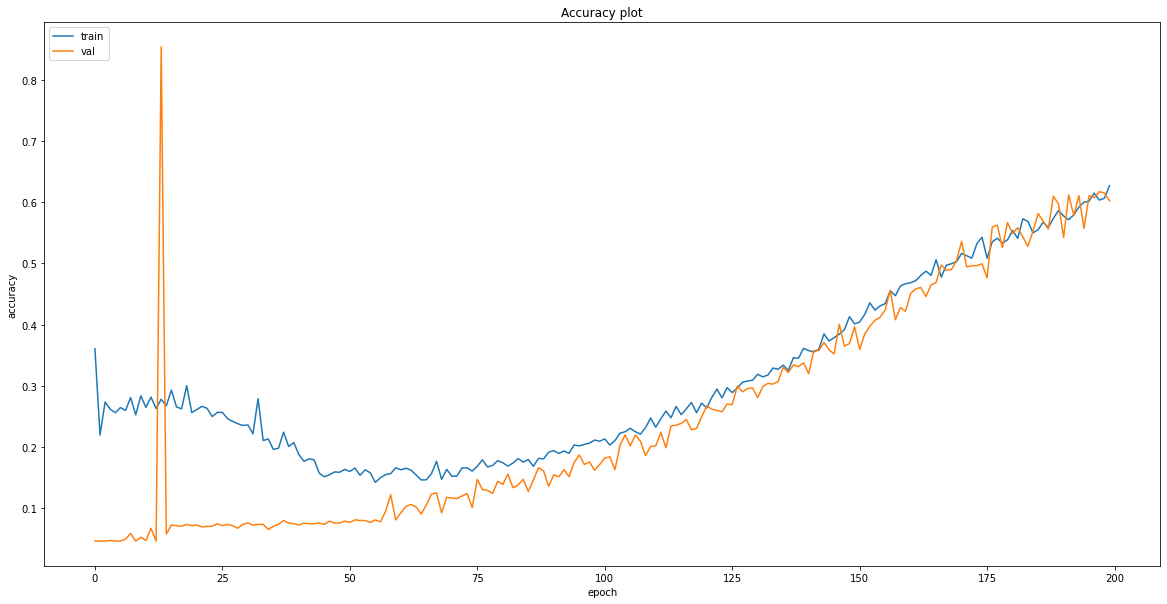

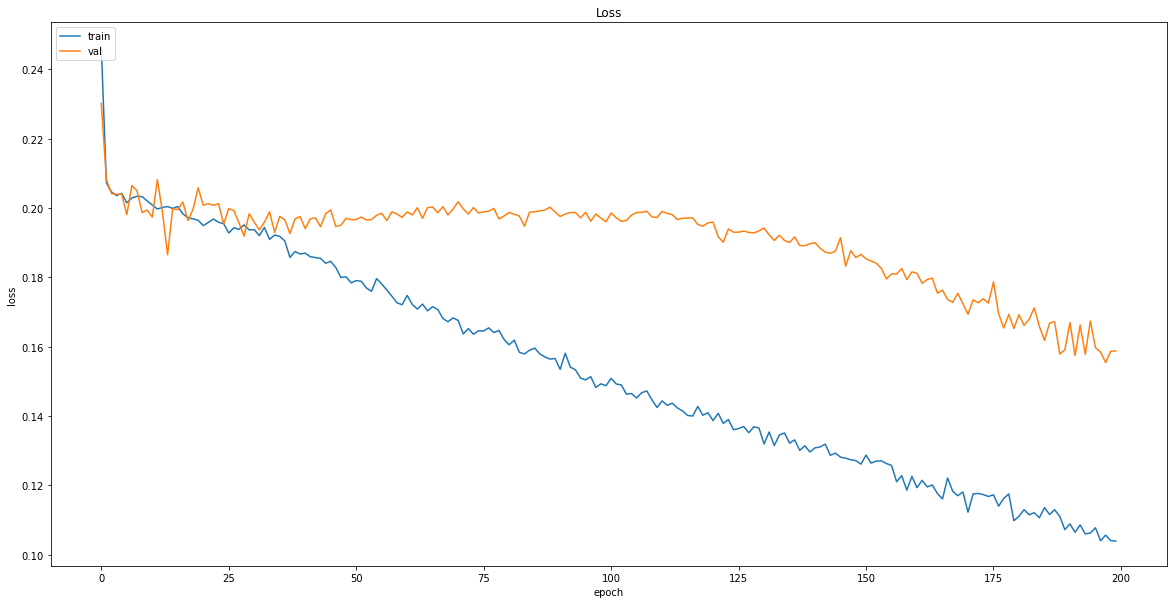

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [155]:
# Save model
model.save("models/{}".format('walmart_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/walmart_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

#### Non-Recession

In [156]:
logger = []

In [157]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


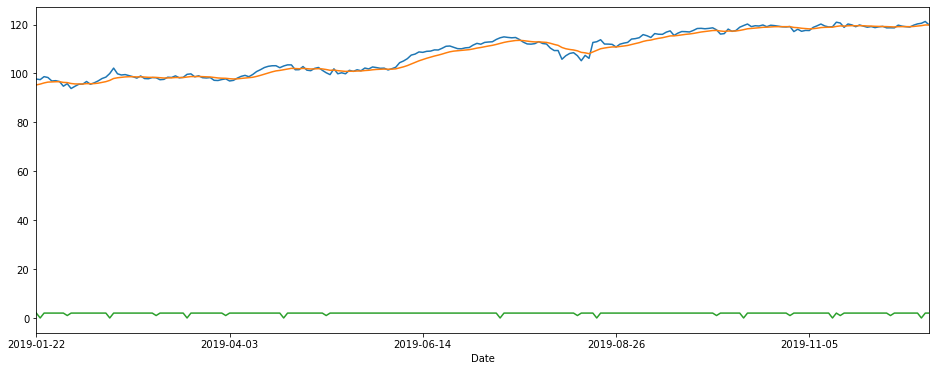

In [158]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [159]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [161]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [162]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [163]:
model = tf.keras.models.load_model("models/walmart_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 10ms/step - loss: 0.1578 - accuracy: 0.5826 - mean_squared_error: 2.6077 - weighted_accuracy: 0.5826 - weighted_mean_squared_error: 2.6077
Test loss: 0.1578439325094223
Test accuracy: 0.5825688242912292


In [164]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 130, 0: 49, 1: 39})

In [165]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [166]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [167]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11    96.199997  95.814812 -60.416634  53751900.0     2.0   
2019-02-12    96.970001  95.874072 -50.480811  59294700.0     2.0   
2019-02-13    97.940002  96.042676 -33.448300  65176000.0     2.0   
2019-02-14    98.519997  96.334572 -16.724150  70634500.0     2.0   
2019-02-15    99.989998  96.670792 -11.165857  77835300.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            0       2  
2019-02-14            2       2  
2019-02-15            2       2

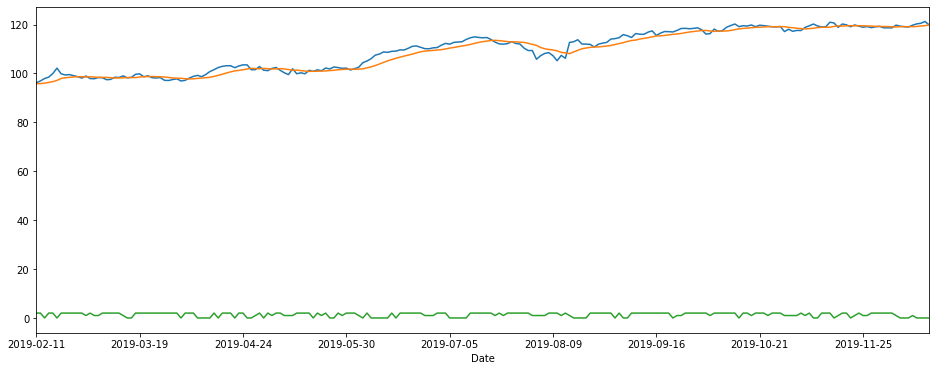

In [168]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

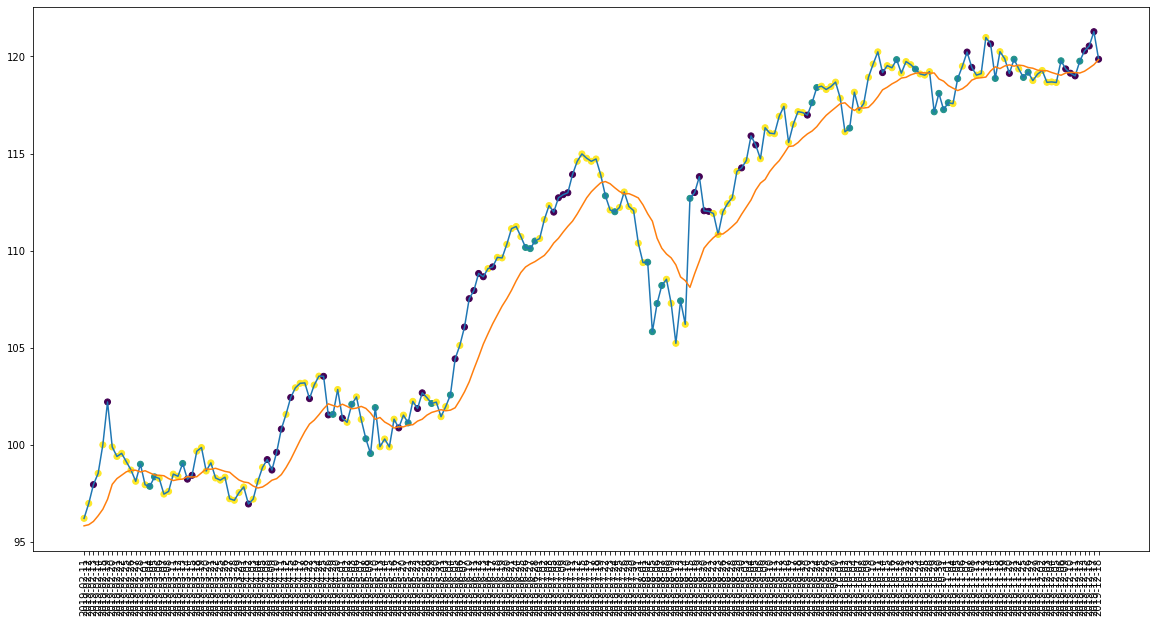

In [169]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

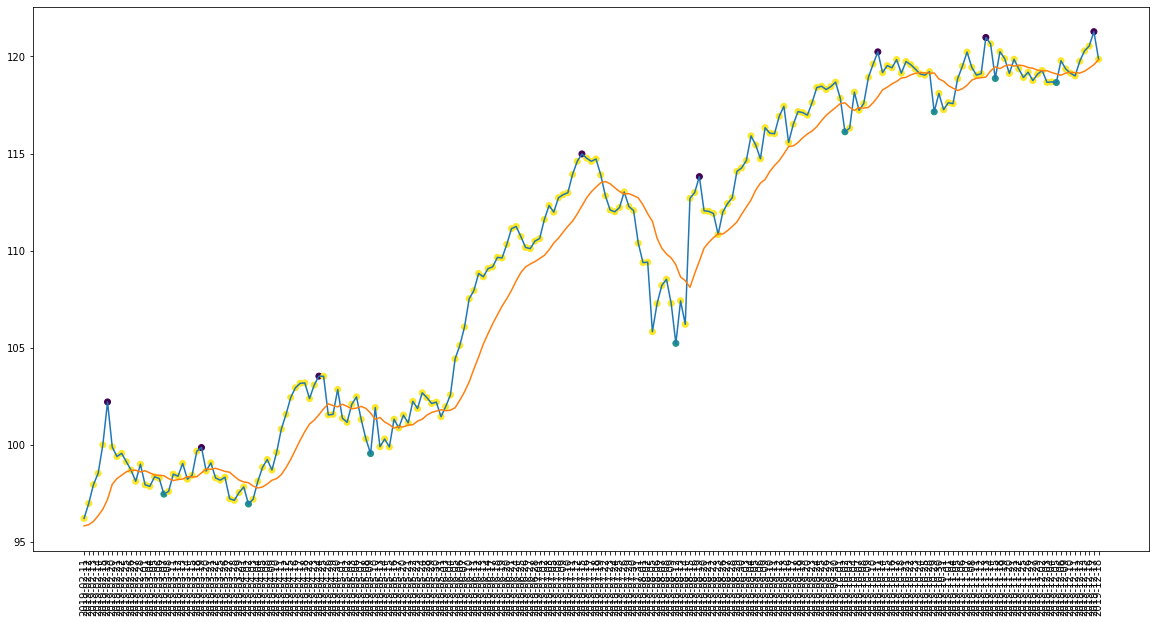

In [170]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [171]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 36
actual holds but predicted sell: 45
actual predicted holds: 121
Percentage buys correct: 37.5%
Percentage sells correct: 37.5%
Percentage holds correct: 59.9009900990099%
actual buys: 8
actual sells: 8
actual holds: 202


In [172]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 53.84615384615385%
Percentage sells correct: 34.69387755102041%
Percentage holds correct: 86.04651162790698%


In [173]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.98999786376952
Shares owned at the moment: 100
Cash capital at the moment: $73.77796421051244


Price increase from previously bought: 5.196113679961822%
Share price: $104.41999816894531
Shares owned at the moment: 0
Cash capital at the moment: $10487.062281608583


Share price: $110.16000366210938
Shares owned at the moment: 94
Cash capital at the moment: $103.54557642364671


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10023.27107781601


Share price: $105.81999969482422
Shares owned at the moment: 94
Cash capital at the moment: $48.83663658142177


Price increase from previously bought: 6.482827289801785%
Share price: $112.98999786376952
Shares owned at the moment: 0
Cash capital at the moment: $10640.688521327971


Share price: $117.62000274658205
Shares owned at the moment: 90
Cash capital at the moment: $25.777323455806254




Capital at the end of test period: $10783.512028236384
profit gained

In [174]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [175]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys correct_sells        correct_holds  \
0       0.642512   45.45454545454545%          0.0%    69.1891891891892%   
1       0.692308   44.44444444444444%         40.0%   71.95767195767196%   
2       0.434783  27.272727272727273%         60.0%   43.54838709677419%   
3       0.399038  28.571428571428573%         25.0%  40.932642487046635%   
4       0.582569                37.5%         37.5%    59.9009900990099%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0  58.064516129032256%              46.875%  84.61538461538461%   
1   66.66666666666667%   62.16216216216216%   86.3013698630137%   
2   56.60377358490566%   55.55555555555556%  78.88888888888889%   
3                52.0%  54.411764705882355%  82.02247191011236%   
4   53.84615384615385%   34.69387755102041%  86.04651162790698%   

         Profit gained    buy_n_hold profit  
0   35.44242451446518%    53.5836826651001%  
1  37.830041926574616%   66.41259749999998%  
2  24.980641415471876%  24.380335833320625%  
3   37.40646288772567%   64.87407351390837%  
4  7.8351202823638415%    23.7578138288879%

### Recession

In [176]:
logger = []

In [177]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [178]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [180]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [181]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [182]:
model = tf.keras.models.load_model("models/walmart_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.5845 - mean_squared_error: 2.7781 - weighted_accuracy: 0.5845 - weighted_mean_squared_error: 2.7781
Test loss: 0.1584547609090805
Test accuracy: 0.5844748616218567


In [183]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 133, 0: 35, 1: 51})

In [184]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [185]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [186]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   115.400002  115.836459 -43.516528 -17373100.0     2.0   
2020-02-12   115.849998  115.769312 -40.219793 -11576300.0     2.0   
2020-02-13   117.440002  115.781725 -30.329757  -6840700.0     2.0   
2020-02-14   117.889999  116.036845  -2.057582  -1507500.0     2.0   
2020-02-18   119.629997  116.321946 -14.561040   6623100.0     0.0   

            predictions  actual  
Date                             
2020-02-11            2       2  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            0       0

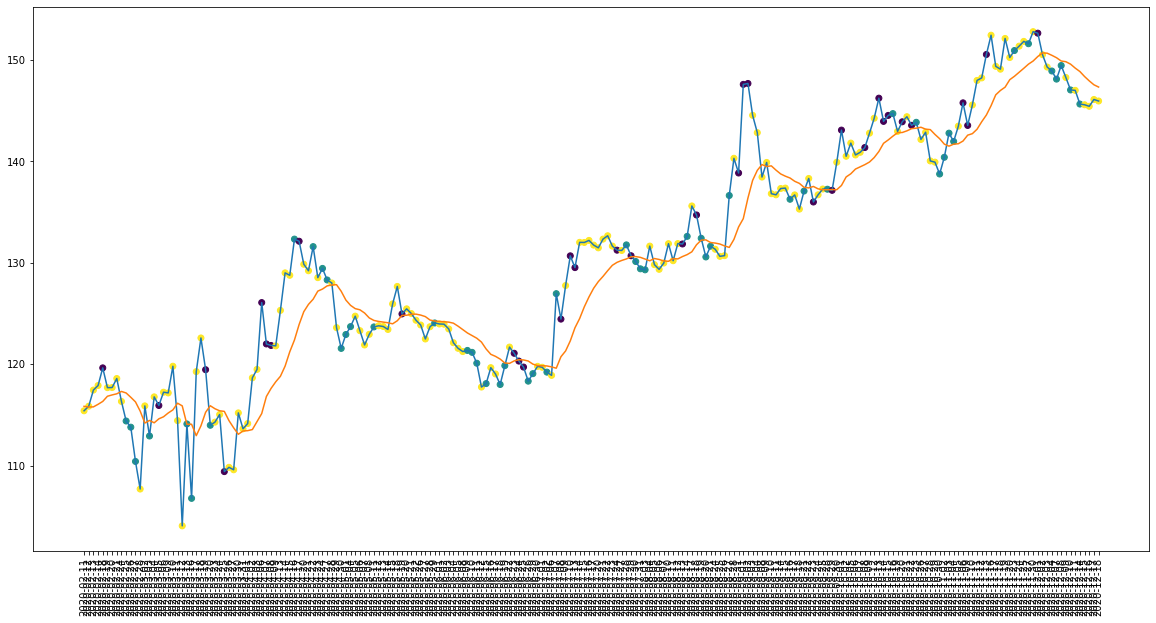

In [187]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

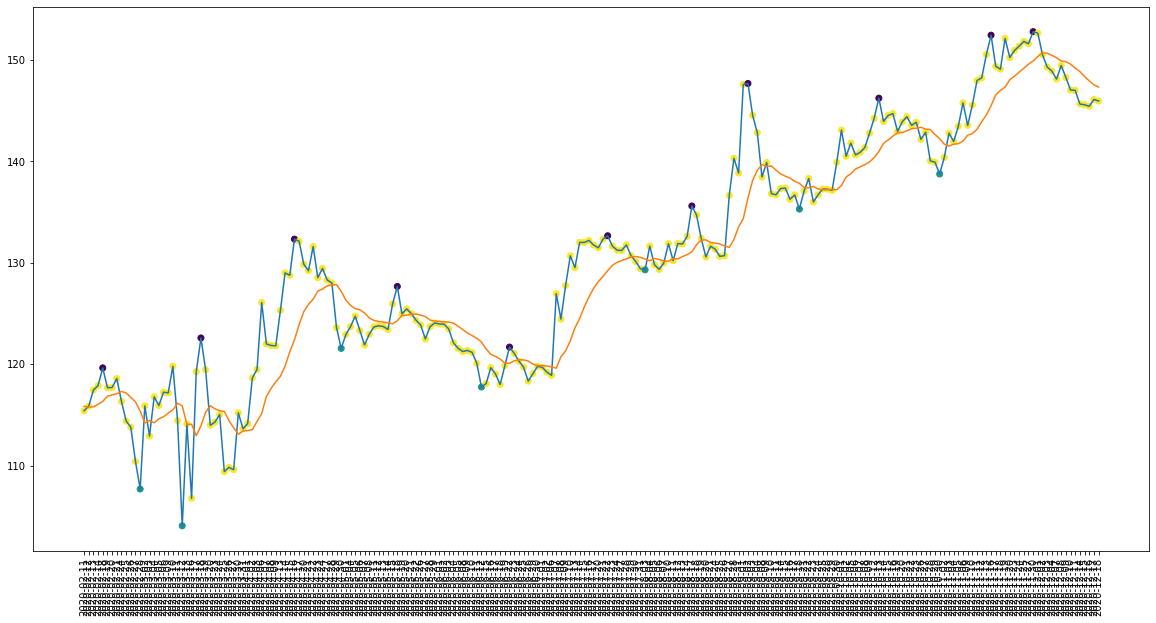

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 47
actual holds but predicted sell: 32
actual predicted holds: 122
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 60.69651741293532%
actual buys: 7
actual sells: 11
actual holds: 201


In [190]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 52.94117647058823%
Percentage sells correct: 48.57142857142857%
Percentage holds correct: 84.84848484848484%


In [191]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $114.38999938964844
Shares owned at the moment: 87
Cash capital at the moment: $20.70224574661188


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9599.08917813301


Share price: $110.4000015258789
Shares owned at the moment: 86
Cash capital at the moment: $78.5794465465533


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9002.271883275982


Share price: $114.0999984741211
Shares owned at the moment: 78
Cash capital at the moment: $77.9975526218368


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $8382.377698789593


Share price: $106.76000213623048
Shares owned at the moment: 78
Cash capital at the moment: $32.19751170539166


Price increase from previously bought: 11.57962526813845%
Share price: $119.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $9323

In [192]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [193]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.642512   45.45454545454545%                 0.0%   
1       0.692308   44.44444444444444%                40.0%   
2       0.434783  27.272727272727273%                60.0%   
3       0.399038  28.571428571428573%                25.0%   
4       0.582569                37.5%                37.5%   
5       0.584475  42.857142857142854%  27.272727272727273%   

         correct_holds     correct_low_buys   correct_high_sells  \
0    69.1891891891892%  58.064516129032256%              46.875%   
1   71.95767195767196%   66.66666666666667%   62.16216216216216%   
2   43.54838709677419%   56.60377358490566%   55.55555555555556%   
3  40.932642487046635%                52.0%  54.411764705882355%   
4    59.9009900990099%   53.84615384615385%   34.69387755102041%   
5   60.69651741293532%   52.94117647058823%   48.57142857142857%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  84.61538461538461%   35.44242451446518%    53.5836826651001%  
1   86.3013698630137%  37.830041926574616%   66.41259749999998%  
2  78.88888888888889%  24.980641415471876%  24.380335833320625%  
3  82.02247191011236%   37.40646288772567%   64.87407351390837%  
4  86.04651162790698%  7.8351202823638415%    23.7578138288879%  
5  84.84848484848484%  -8.473212591838946%   25.65490331684112%

## Fresh Del Monte Produce Inc

In [194]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


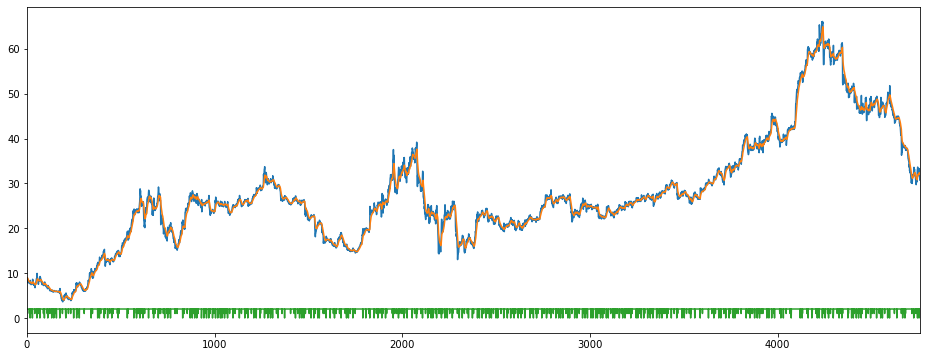

In [195]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [196]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0

In [197]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [198]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [200]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

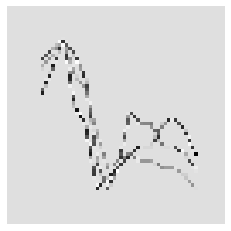

In [201]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [202]:
X = X/255

In [203]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [204]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [205]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [207]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.1893939393939394, 2: 0.3671890114142}
Epoch 1/200
30/30 [==============================] - 2s 73ms/step - loss: 0.2431 - accuracy: 0.4060 - mse: 1.5970 - weighted_accuracy: 0.3027 - weighted_mse: 1.6980 - val_loss: 0.1961 - val_accuracy: 0.0464 - val_mse: 1.0123 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 1.0123
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2056 - accuracy: 0.3327 - mse: 1.1527 - weighted_accuracy: 0.3492 - weighted_mse: 1.1799 - val_loss: 0.2011 - val_accuracy: 0.3425 - val_mse: 0.8509 - val_weighted_accuracy: 0.3425 - val_weighted_mse: 0.8509
Epoch 3/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2027 - accuracy: 0.3807 - mse: 1.1647 - weighted_accuracy: 0.3580 - weighted_mse: 1.1895 - val_loss: 0.1976 - val_accuracy: 0.4089 - val_mse: 0.8822 - val_weighted_accuracy: 0.4089 - val_weighted_mse: 0.8822
Epoch 4/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2038 -

30/30 [==============================] - 0s 11ms/step - loss: 0.1956 - accuracy: 0.2566 - mse: 1.2005 - weighted_accuracy: 0.3837 - weighted_mse: 1.1955 - val_loss: 0.1959 - val_accuracy: 0.0717 - val_mse: 1.0388 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.0388
Epoch 29/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1952 - accuracy: 0.2484 - mse: 1.2232 - weighted_accuracy: 0.4133 - weighted_mse: 1.1848 - val_loss: 0.1928 - val_accuracy: 0.0685 - val_mse: 1.1025 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 1.1025
Epoch 30/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1939 - accuracy: 0.2534 - mse: 1.2104 - weighted_accuracy: 0.3952 - weighted_mse: 1.1998 - val_loss: 0.1962 - val_accuracy: 0.0706 - val_mse: 0.9877 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9877
Epoch 31/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1944 - accuracy: 0.2516 - mse: 1.2070 - weighted_accuracy: 0.3873 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1782 - accuracy: 0.1546 - mse: 1.3092 - weighted_accuracy: 0.5268 - weighted_mse: 1.2451 - val_loss: 0.1986 - val_accuracy: 0.0717 - val_mse: 1.1784 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.1784
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1782 - accuracy: 0.1504 - mse: 1.3354 - weighted_accuracy: 0.5126 - weighted_mse: 1.2805 - val_loss: 0.1981 - val_accuracy: 0.0748 - val_mse: 1.0667 - val_weighted_accuracy: 0.0748 - val_weighted_mse: 1.0667
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1777 - accuracy: 0.1523 - mse: 1.2923 - weighted_accuracy: 0.5188 - weighted_mse: 1.2544 - val_loss: 0.1949 - val_accuracy: 0.0906 - val_mse: 1.1452 - val_weighted_accuracy: 0.0906 - val_weighted_mse: 1.1452
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1763 - accuracy: 0.1573 - mse: 1.3352 - weighted_accuracy: 0.5223 - 

Epoch 86/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1602 - accuracy: 0.1783 - mse: 1.5032 - weighted_accuracy: 0.6062 - weighted_mse: 1.4274 - val_loss: 0.1970 - val_accuracy: 0.1770 - val_mse: 1.2514 - val_weighted_accuracy: 0.1770 - val_weighted_mse: 1.2514
Epoch 87/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1568 - accuracy: 0.2055 - mse: 1.4888 - weighted_accuracy: 0.6235 - weighted_mse: 1.4274 - val_loss: 0.1944 - val_accuracy: 0.1886 - val_mse: 1.3254 - val_weighted_accuracy: 0.1886 - val_weighted_mse: 1.3254
Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1586 - accuracy: 0.1826 - mse: 1.4971 - weighted_accuracy: 0.6186 - weighted_mse: 1.4383 - val_loss: 0.1964 - val_accuracy: 0.1960 - val_mse: 1.3439 - val_weighted_accuracy: 0.1960 - val_weighted_mse: 1.3439
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1577 - accuracy: 0.1910 - mse: 1.4825 - weighted_accuracy: 0.6108 - 

Epoch 115/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1403 - accuracy: 0.2900 - mse: 1.7165 - weighted_accuracy: 0.6852 - weighted_mse: 1.7451 - val_loss: 0.1935 - val_accuracy: 0.2677 - val_mse: 1.4965 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.4965
Epoch 116/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1385 - accuracy: 0.2777 - mse: 1.7192 - weighted_accuracy: 0.6985 - weighted_mse: 1.7484 - val_loss: 0.1905 - val_accuracy: 0.2908 - val_mse: 1.5381 - val_weighted_accuracy: 0.2908 - val_weighted_mse: 1.5381
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1390 - accuracy: 0.3022 - mse: 1.7106 - weighted_accuracy: 0.6895 - weighted_mse: 1.7506 - val_loss: 0.1916 - val_accuracy: 0.2929 - val_mse: 1.5954 - val_weighted_accuracy: 0.2929 - val_weighted_mse: 1.5954
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1405 - accuracy: 0.2840 - mse: 1.8078 - weighted_accuracy: 0.684

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1262 - accuracy: 0.4165 - mse: 2.0291 - weighted_accuracy: 0.7478 - weighted_mse: 2.2953 - val_loss: 0.1779 - val_accuracy: 0.4552 - val_mse: 1.8973 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 1.8973
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1275 - accuracy: 0.4081 - mse: 2.0750 - weighted_accuracy: 0.7428 - weighted_mse: 2.3058 - val_loss: 0.1790 - val_accuracy: 0.4215 - val_mse: 1.8160 - val_weighted_accuracy: 0.4215 - val_weighted_mse: 1.8160
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1247 - accuracy: 0.4241 - mse: 2.0590 - weighted_accuracy: 0.7379 - weighted_mse: 2.3504 - val_loss: 0.1826 - val_accuracy: 0.3867 - val_mse: 1.7921 - val_weighted_accuracy: 0.3867 - val_weighted_mse: 1.7921
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1236 - accuracy: 0.4273 - mse: 2.1322 - weighted_accuracy: 0.7590 -

Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1113 - accuracy: 0.5522 - mse: 2.5841 - weighted_accuracy: 0.8067 - weighted_mse: 3.1814 - val_loss: 0.1660 - val_accuracy: 0.5374 - val_mse: 2.0670 - val_weighted_accuracy: 0.5374 - val_weighted_mse: 2.0670
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1124 - accuracy: 0.5540 - mse: 2.5265 - weighted_accuracy: 0.7964 - weighted_mse: 3.1872 - val_loss: 0.1643 - val_accuracy: 0.5669 - val_mse: 2.2335 - val_weighted_accuracy: 0.5669 - val_weighted_mse: 2.2335
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1115 - accuracy: 0.5587 - mse: 2.6044 - weighted_accuracy: 0.8072 - weighted_mse: 3.1803 - val_loss: 0.1604 - val_accuracy: 0.5796 - val_mse: 2.1322 - val_weighted_accuracy: 0.5796 - val_weighted_mse: 2.1322
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1108 - accuracy: 0.5640 - mse: 2.5896 - weighted_accuracy: 0.8002 -

In [208]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1462785005569458
Test accuracy: 0.6701791286468506


In [209]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.8347661  -0.83509934 -0.13219862]
 [-0.08850233 -2.3508418  -0.63663054]
 [-0.9667019  -1.5129857  -0.21922545]
 ...
 [-1.1908553  -1.0452534  -0.21241885]
 [-0.6807924  -1.5266567  -0.3326499 ]
 [-1.1568893  -1.1099162  -0.16135317]]


Counter({2: 674, 0: 105, 1: 170})

In [210]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [211]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 13
actual buys but predicted sell: 0
actual buys but predicted hold: 31
actual sells but predicted buy: 7
actual predicted sells: 8
actual sells but predicted hold: 28
actual holds but predicted buy: 150
actual holds but predicted sell: 97
actual predicted holds: 615
Percentage buys correct: 29.545454545454547%
Percentage sells correct: 18.6046511627907%
Percentage holds correct: 71.34570765661253%
actual buys: 44
actual sells: 43
actual holds: 862


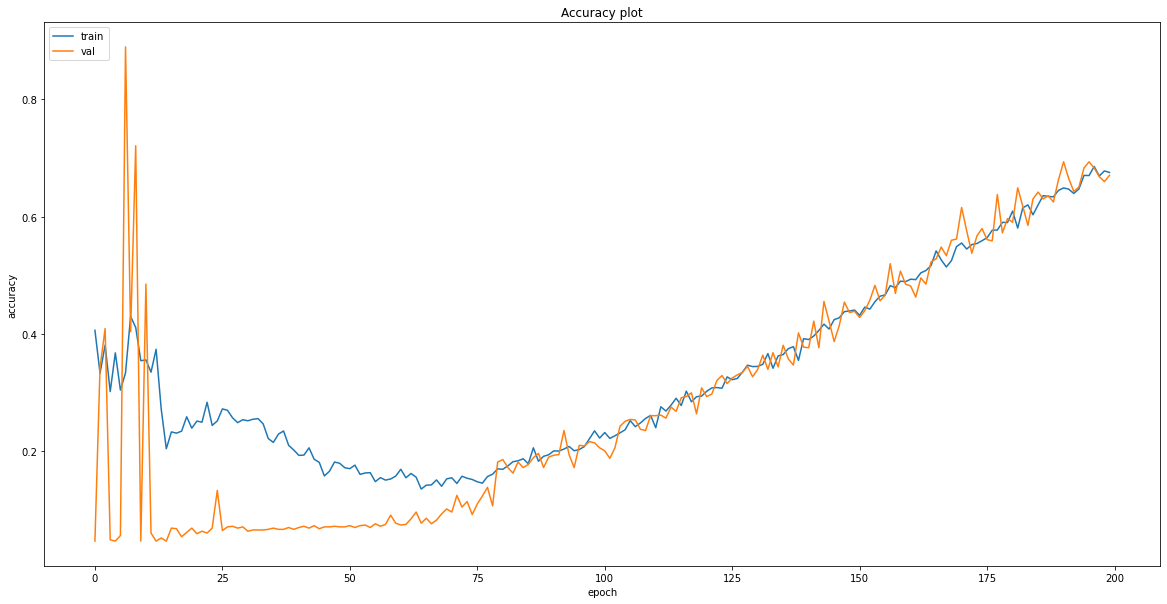

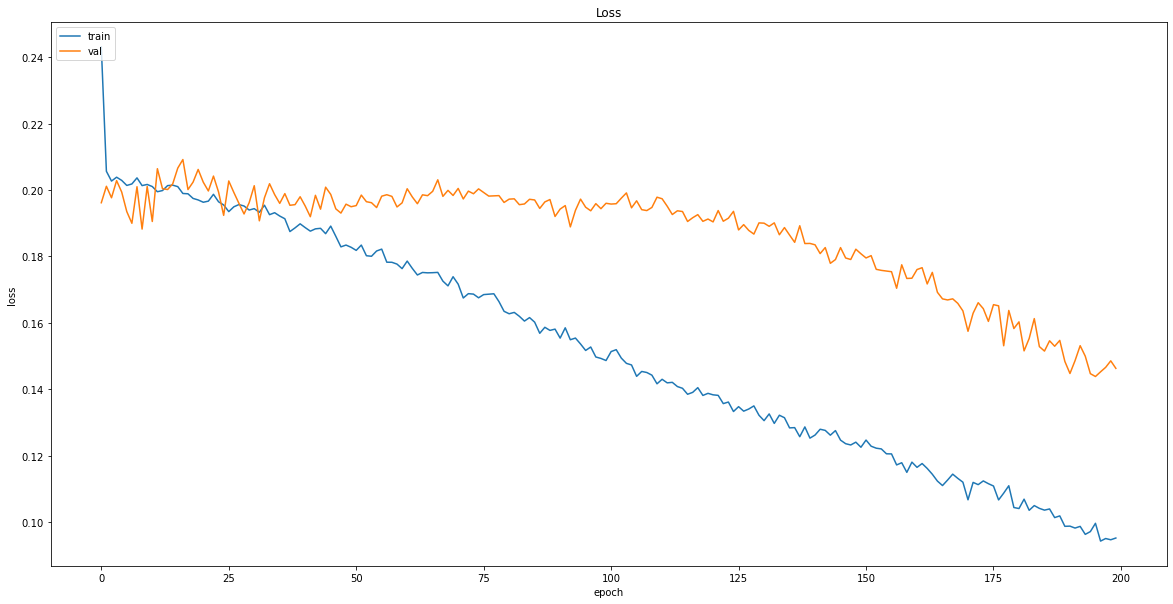

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [213]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [214]:
logger = []

In [215]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [216]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [218]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [219]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [220]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1469 - accuracy: 0.6560 - mean_squared_error: 2.2603 - weighted_accuracy: 0.6560 - weighted_mean_squared_error: 2.2603
Test loss: 0.14687535166740417
Test accuracy: 0.6559633016586304


In [221]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 29, 2: 153, 1: 36})

In [222]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [223]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [224]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                            
2019-02-11    33.880001  31.978904  -0.753738  2502700.0     2.0            0   
2019-02-12    34.610001  32.271381  -0.536205  2611700.0     2.0            2   
2019-02-13    34.810001  32.631168  -5.603413  2713000.0     2.0            0   
2019-02-14    34.430000  32.966373  -5.668932  2794100.0     2.0            2   
2019-02-15    35.220001  33.191547 -14.285733  2675800.0     0.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       0

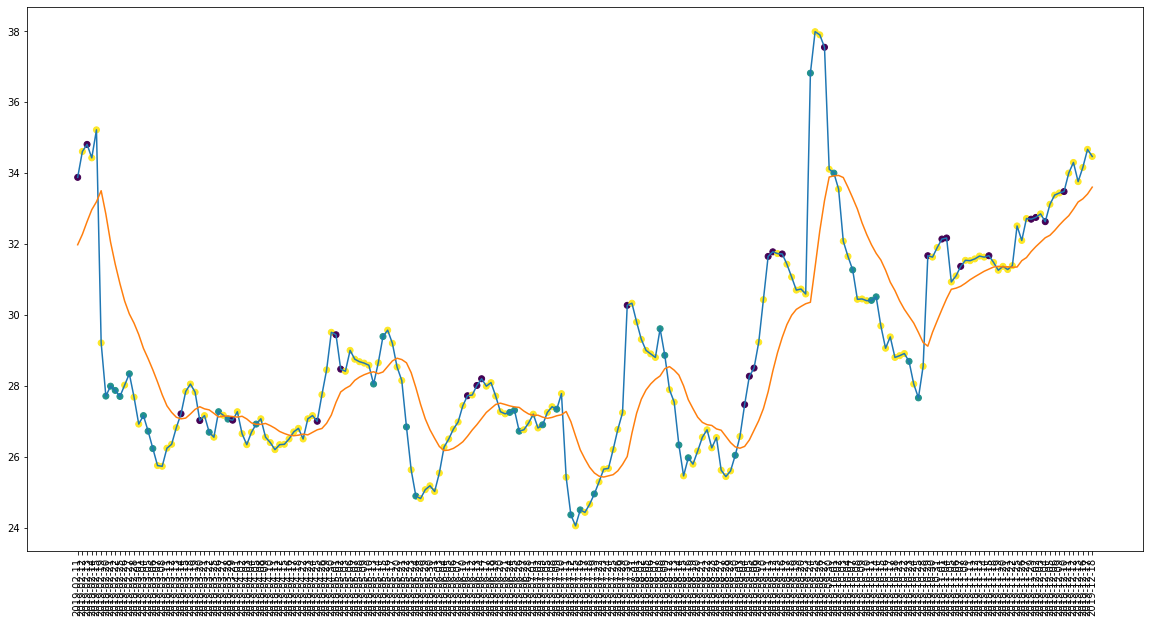

In [225]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

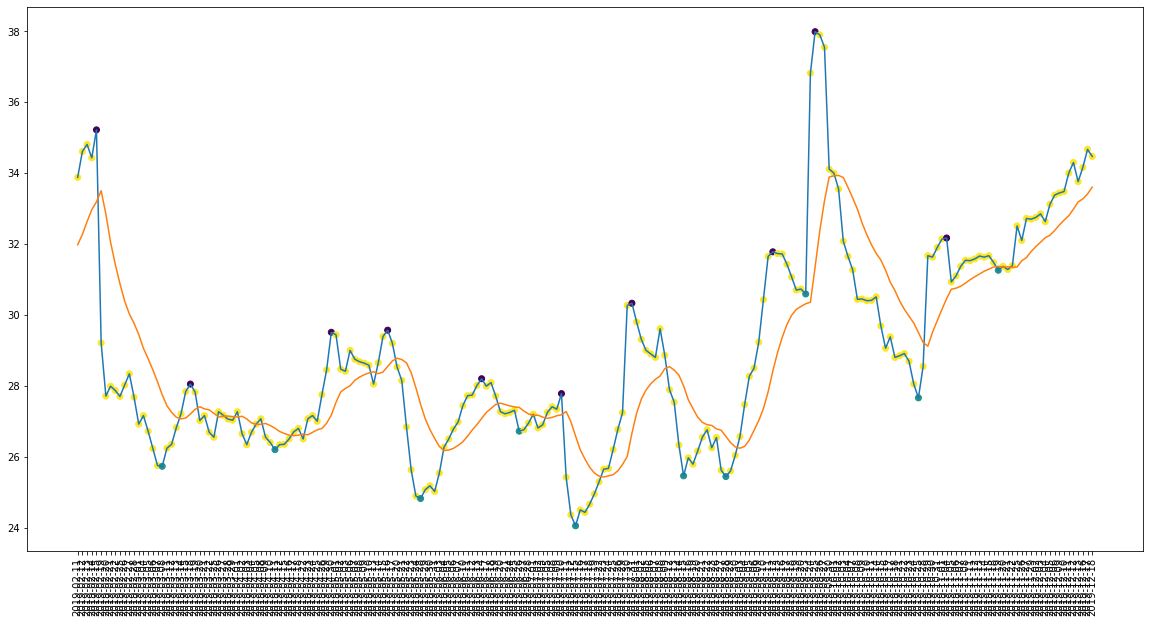

In [226]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [227]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 34
actual holds but predicted sell: 26
actual predicted holds: 138
Percentage buys correct: 20.0%
Percentage sells correct: 30.0%
Percentage holds correct: 69.6969696969697%
actual buys: 10
actual sells: 10
actual holds: 198


In [228]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 53.57142857142857%
Percentage holds correct: 84.9673202614379%


In [229]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.709999084472656
Shares owned at the moment: 359
Cash capital at the moment: $24.753632078170995


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9662.456889392375


Share price: $27.15999984741211
Shares owned at the moment: 354
Cash capital at the moment: $21.376683557033175


Stop Loss Activated!

Share price: $26.229999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9281.261616954325


Share price: $26.229999542236328
Shares owned at the moment: 352
Cash capital at the moment: $22.911138530253083


Price increase from previously bought: 11.930091781880936%
Share price: $29.440000534057607
Shares owned at the moment: 0
Cash capital at the moment: $10357.293406001563


Share price: $28.04999923706055
Shares owned at the moment: 368
Cash capital at the moment: $6.507087535374012


Stop Loss Activated!

Share price: $26.84000015258789
Shares owned at the moment: 0
Cash capital at the

In [230]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [231]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.642512   45.45454545454545%                 0.0%   
1       0.692308   44.44444444444444%                40.0%   
2       0.434783  27.272727272727273%                60.0%   
3       0.399038  28.571428571428573%                25.0%   
4       0.582569                37.5%                37.5%   
5       0.584475  42.857142857142854%  27.272727272727273%   
6       0.655963                20.0%                30.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0    69.1891891891892%  58.064516129032256%              46.875%   
1   71.95767195767196%   66.66666666666667%   62.16216216216216%   
2   43.54838709677419%   56.60377358490566%   55.55555555555556%   
3  40.932642487046635%                52.0%  54.411764705882355%   
4    59.9009900990099%   53.84615384615385%   34.69387755102041%   
5   60.69651741293532%   52.94117647058823%   48.57142857142857%   
6    69.6969696969697%   44.44444444444444%   53.57142857142857%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  84.61538461538461%   35.44242451446518%    53.5836826651001%  
1   86.3013698630137%  37.830041926574616%   66.41259749999998%  
2  78.88888888888889%  24.980641415471876%  24.380335833320625%  
3  82.02247191011236%   37.40646288772567%   64.87407351390837%  
4  86.04651162790698%  7.8351202823638415%    23.7578138288879%  
5  84.84848484848484%  -8.473212591838946%   25.65490331684112%  
6   84.9673202614379%  -2.317273008709053%  1.1819906801032993%

### recession

In [232]:
logger = []

In [233]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [234]:
willr_data = []
price_data = []
#ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
#data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        #data_15_ema_arr = min_max_scaler.fit_transform(#data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        #ema_data.append(#data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        #data_15_ema = #data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        #data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
#ema_data = np.array(#ema_data)
obv_data = np.array(obv_data)

In [235]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    #l = #ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    #ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [236]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [237]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [238]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.7215 - mean_squared_error: 2.4192 - weighted_accuracy: 0.7215 - weighted_mean_squared_error: 2.4192
Test loss: 0.13960061967372894
Test accuracy: 0.7214611768722534


In [239]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 155, 0: 24, 1: 40})

In [240]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [241]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [242]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels  predictions  \
Date                                                                           
2020-02-11    33.930000  32.680842 -26.373606  310600.0     2.0            2   
2020-02-12    34.410000  32.873020 -19.505473  431300.0     2.0            0   
2020-02-13    34.240002  33.109478 -14.750004  582800.0     2.0            2   
2020-02-14    34.480000  33.283405 -18.999958  490800.0     0.0            0   
2020-02-18    34.009998  33.467496 -13.000011  587800.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       2  
2020-02-13       2  
2020-02-14       0  
2020-02-18       2

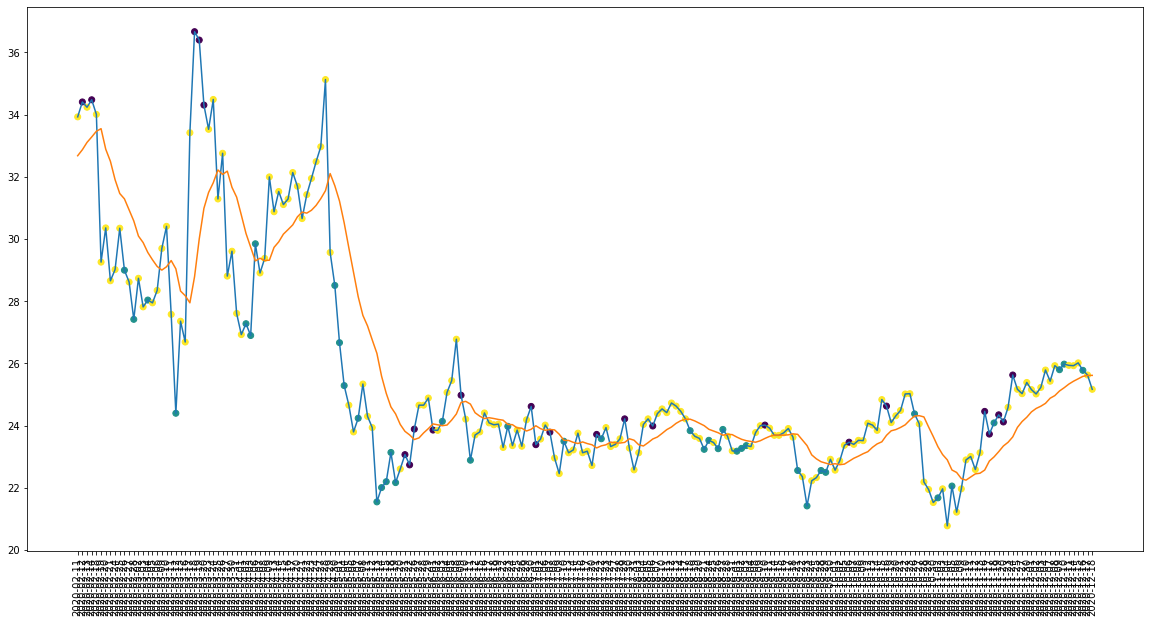

In [243]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

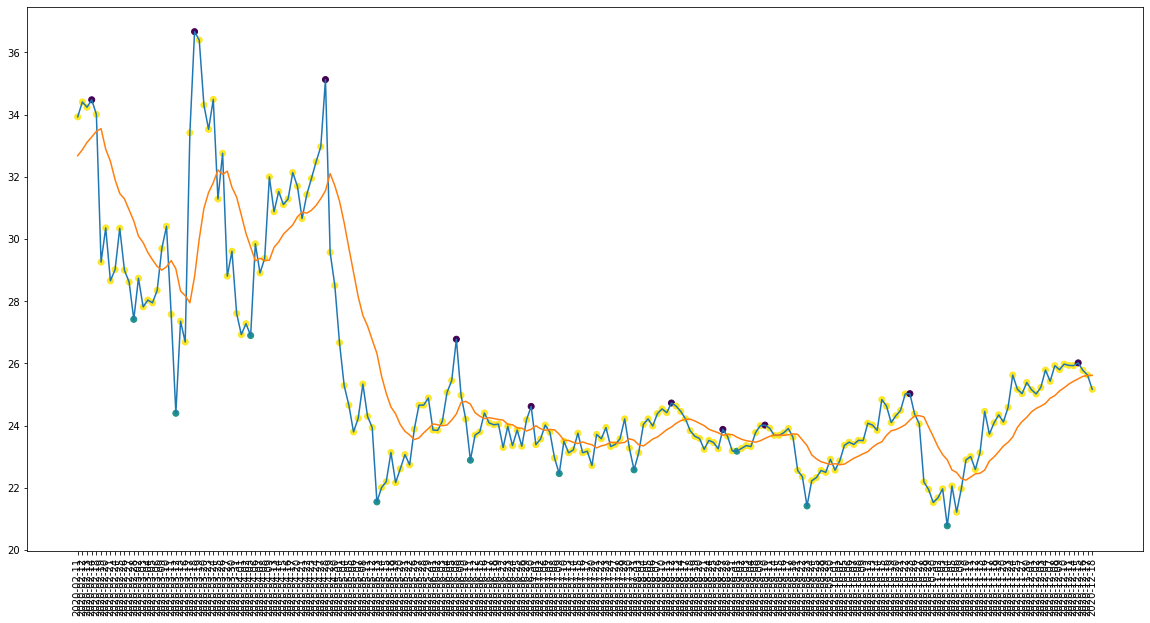

In [244]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [245]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 32
actual holds but predicted sell: 20
actual predicted holds: 147
Percentage buys correct: 70.0%
Percentage sells correct: 40.0%
Percentage holds correct: 73.86934673366834%
actual buys: 10
actual sells: 10
actual holds: 199


In [246]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 60.0%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 85.71428571428571%


In [247]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $29.0
Shares owned at the moment: 343
Cash capital at the moment: $25.64574999999968


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9404.841861096858


Share price: $27.420000076293945
Shares owned at the moment: 342
Cash capital at the moment: $1.4133249325750512


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $8323.2649948287


Share price: $24.399999618530273
Shares owned at the moment: 340
Cash capital at the moment: $4.451124885081299


Price increase from previously bought: 49.874724598519094%
Share price: $36.66999816894531
Shares owned at the moment: 0
Cash capital at the moment: $12437.964054038523


Share price: $27.28000068664551
Shares owned at the moment: 454
Cash capital at the moment: $18.784661444182348


Stop Loss Activated!

Share price: $25.290000915527344
Shares owned at the moment: 0
Cash capital at the moment: $11468.

In [248]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [249]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.642512   45.45454545454545%                 0.0%   
1       0.692308   44.44444444444444%                40.0%   
2       0.434783  27.272727272727273%                60.0%   
3       0.399038  28.571428571428573%                25.0%   
4       0.582569                37.5%                37.5%   
5       0.584475  42.857142857142854%  27.272727272727273%   
6       0.655963                20.0%                30.0%   
7       0.721461                70.0%                40.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0    69.1891891891892%  58.064516129032256%              46.875%   
1   71.95767195767196%   66.66666666666667%   62.16216216216216%   
2   43.54838709677419%   56.60377358490566%   55.55555555555556%   
3  40.932642487046635%                52.0%  54.411764705882355%   
4    59.9009900990099%   53.84615384615385%   34.69387755102041%   
5   60.69651741293532%   52.94117647058823%   48.57142857142857%   
6    69.6969696969697%   44.44444444444444%   53.57142857142857%   
7   73.86934673366834%                60.0%   66.66666666666667%   

    correct_mid_holds         Profit gained    buy_n_hold profit  
0  84.61538461538461%    35.44242451446518%    53.5836826651001%  
1   86.3013698630137%   37.830041926574616%   66.41259749999998%  
2  78.88888888888889%   24.980641415471876%  24.380335833320625%  
3  82.02247191011236%    37.40646288772567%   64.87407351390837%  
4  86.04651162790698%   7.8351202823638415%    23.7578138288879%  
5  84.84848484848484%   -8.473212591838946%   25.65490331684112%  
6   84.9673202614379%   -2.317273008709053%  1.1819906801032993%  
7  85.71428571428571%  -20.014177705559987%  -26.14299892369747%

In [250]:
experiment

'No EMA CNN Images Experiments - noncyclic'

In [251]:
log.to_csv('{}.csv'.format(experiment))